# **Deteksi SQL Injection menggunakan Teknik Pembelajaran Mesin dengan Algoritma Random Forest**

#**1. Pendahuluan**

<h2> 1.1 Latar Belakang </h2>

<p>SQL Injection juga disebut sebagai query SQLI adalah teknik dimana
penyerang membuat atau mengubah query SQL yaitu penyerang atau hacker yang ingin mendapatkan
akses ke database backend dan informasi yang dibuat organisasi / perusahaan
query SQL berbahaya yang dapat dengan mudah mendapatkan informasi yang penting
kepada organisasi/perusahaan. </p>

Rumusan Masalah
- Apakah Algoritma Random Forest dapat ditugaskan untuk memprediksi kueri sql yang dibuat secara internal oleh web aplikasi adalah kueri SQLI atau kueri SQL asli?
- Seberapa akurat algoritma ini dapat membedakan antara kueri SQLI atau kueri SQL asli?

<h2> 1.2 Tinjauan Pustaka </h2>

Dataset Source : https://www.kaggle.com/code/princeroy15/sql-injection-detection-by-machine-learning/input
<br><br>Sumber Tambahan
- https://hrcak.srce.hr/file/367636
- https://www.irjet.net/archives/V8/i7/IRJET-V8I7515.pdf
- https://www.kaggle.com/datasets/siddharthkumar25/malicious-and-benign-urls
- https://www.matec-conferences.org/articles/matecconf/pdf/2018/32/matecconf_smima2018_01004.pdf
- https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-%20%20%20%20nlp/#:~:text=Tokenization%20is%20a%20way%20of,n%2Dgram%20characters

In [ ]:
#Import Universal Library for Data Analysis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from scipy.stats import boxcox
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#**2. Penjelasan Data**

##**2.1 Data Overview**

<p>
- Dataset berisi dua kolom: Sentence, label.<br>
- Kolom sentence berisi kombinasi kueri SQLI, kueri SQL Asli
dan teks biasa.<br>
- Kolom label berisi nilai 1 dan 0. Di mana 1 mewakili Tertentu
Kalimat bisa mendapatkan akses ke database yaitu SQLI Kalimat dan 0 mewakili tidak bisa mendapatkan akses ke database yaitu bisa berupa Kalimat Sql Asli atau teks biasa.<br>
- Jumlah baris dalam kolom 33761.<br>
</p>


###**2.1.1 Example Data point**

<pre>
"Sentence", "Label"
" or pg_sleep ( __TIME__ ) --"	, 1
"create user name identified by pass123 temporary tablespace temp default tablespace users;", 1
"SELECT sure FROM silent UNION SELECT sides FROM excellent ORDER BY wing", 0
</pre>

##**2.2 Identifikasikan masalah sebenarnya ke permasalahan Machine Learning**

###**2.2.1 Type of Machine Leaning Problem**

<p> Ini adalah masalah klasifikasi Biner. Untuk Kalimat SQl tertentu. Kita perlu
memprediksi Kalimat yang diberikan bisa mendapatkan akses ke database atau tidak.</p>

###**2.2.2 Performance Metric**

Metrics(s):
- Confusion Matrix
- Recall rate.
- Precison rate.
- F1-Score.

#**3. Analisis Data (EDA)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**3.1 Reading data and basic stats**

In [ ]:
path = '/content/drive/MyDrive/SKRIPSI/Dataset/sqliv2.csv'
data = pd.read_csv(path, encoding='utf-16',lineterminator='\n')

###**3.1.1 Calculating the number of rows in a dataset**

In [ ]:
print("Data Shape:", data.shape)
print("Number of rows in dataset : {} ".format(data.shape[0]))

Data Shape: (33761, 2)
Number of rows in dataset : 33761 


###**3.1.2 number of columns in a dataset**

In [ ]:
print("Number of columns in dataset : {}".format(data.shape[1]))

Number of columns in dataset : 2


In [ ]:
print("The dataset columns are : ")

for i in data.columns:
    print(i)

The dataset columns are : 
Sentence
Label


In [ ]:
#display 10 baris pertama
data.head(10)

Sentence  Label
0                                                NaN      1
1                      " or pg_sleep ( __TIME__ ) --      1
2  create user name identified by pass123 tempora...      1
3                                                %29      1
4  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1
5   select * from users where id = '1' or @ @1 = ...      1
6   select * from users where id = 1 or 1#" (  un...      1
7  ' select name from syscolumns where id  =   ( ...      1
8   select * from users where id = 1 +$+ or 1 = 1...      1
9  1; ( load_file ( char ( 47,101,116,99,47,112,9...      1

###**3.1.3 Basic information about the dataset columns**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33761 entries, 0 to 33760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  33757 non-null  object
 1   Label     33761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 527.6+ KB


Kolom data terdiri dari:
- Kalimat : Berisi Kalimat SQLI, Kalimat SQL atau teks biasa dan bertipe objek
- Label : Label yang coba kita prediksi yaitu 1 berarti Kalimat SQLI dan 0 berarti Kalimat SQL Normal atau teks biasa

In [ ]:
data.describe()

Label
count  33761.000000
mean       0.339326
std        0.473488
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [ ]:
# Returns a random selection elements (25)
data.sample(25, random_state = 42)

Sentence  Label
2304    Häußler commented flood found Gechingen unpre...      0
32525                                               sean      0
14694                                 lamarr@tardos.mobi      0
8137   -7069 )  union all select 6638,6638,6638,6638,...      1
16722                                   4381135407580429      0
30813                                          asperillo      0
7609   1'  )  )   procedure analyse ( extractvalue ( ...      1
26180                                           bluethne      0
1090                       New York City psychiatrist Dr      0
10609  1' or 8466 = benchmark ( 5000000,md5 ( 0x694a4...      1
20875                                     sobrino coyoma      0
3184    O &apos;Malley said new charge really raising...      0
19753                                               7553      0
3394    &quot; During period investigated , Ms Pawlby...      0
28208                                       ladronzue_lo      0
2275    &quot; Mr Ditta accused abusing position crim...      0
17410                                        cot reixach      0
4740   if ( 8537 = 7034 )  select 8537 else drop func...      1
17918                                          99783130e      0
23914                                        enjalbegada      0
22860                                          16359311d      0
23152                                      pujals ogando      0
1888    The austerity imposed Berlin European Central...      0
14982                                      m9gnificen5i5      0
11644  -4965 )  as imga where 3705 = 3705 union all s...      1

##**3.2 Distribution of data points among output classes**

Total data points that belongs to label 1 is 11456 and percent is 33.93
Total data points that belongs to label 0 is 22305 and percent is 66.07


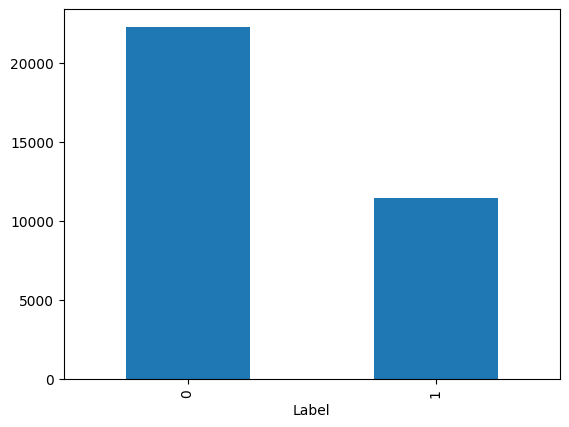

In [ ]:
'''
periksa bagaimana titik data didistribusikan di antara label
yaitu memeriksa berapa banyak yang termasuk dalam label 1 dan berapa banyak yang termasuk dalam label 0
'''
#using group by command and bar plot
data.groupby('Label')['Sentence'].count().plot.bar()

#printing how many percent of data points belongs to label 1 and label 0
print("Total data points that belongs to label 1 is {} and percent is {}".format(data['Label'].value_counts()[1],round((data['Label'].value_counts()[1] / data.shape[0]) * 100, 2)))
print("Total data points that belongs to label 0 is {} and percent is {}".format(data['Label'].value_counts()[0],round((data['Label'].value_counts()[0] / data.shape[0]) * 100, 2)))


Pengamatan:
- Mayoritas titik data termasuk dalam label 0 yaitu kueri sql normal atau teks biasa lebih banyak berada di titik data
- ada ketidakseimbangan kelas antar titik data.

###**3.2.2 Checking for Duplicates**

In [ ]:
data.dropna(inplace=True)
data.isnull().sum()

Sentence    0
Label       0
dtype: int64

In [ ]:
#checking if there any duplicate rows present in dataset
data.duplicated(subset = ['Sentence','Label']).sum()

30

In [ ]:
boolean_mask = data.duplicated(subset = ['Sentence','Label'])
data[boolean_mask]

Sentence  Label
3952          1 or benchmark ( 10000000,MD5 ( 1  )  )  #      1
3954                       " or pg_sleep ( __TIME__ ) --      1
3955                   1  )  )   or sleep ( __TIME__ ) #      1
3957   1  )  )   or benchmark ( 10000000,MD5 ( 1  )  ...      1
3958                    " )  or pg_sleep ( __TIME__ ) --      1
3960               1  )  )   or pg_sleep ( __TIME__ ) --      1
3961                       1 or pg_sleep ( __TIME__ ) --      1
3964   "  )  )   or benchmark ( 10000000,MD5 ( 1  )  ...      1
3965               benchmark ( 10000000,MD5 ( 1  )  )  #      1
3966            "  )  )  ;waitfor delay '0:0:__TIME__'--      1
3967                                       # from wapiti      1
3969          " or benchmark ( 10000000,MD5 ( 1  )  )  #      1
3970       1 )  or benchmark ( 10000000,MD5 ( 1  )  )  #      1
3973                        1 )  or sleep ( __TIME__ ) #      1
3974                    1 )  or pg_sleep ( __TIME__ ) --      1
3976                    ";waitfor delay '0:0:__TIME__'--      1
3977                     " )  or sleep ( __TIME__ )  = "      1
3981       " )  or benchmark ( 10000000,MD5 ( 1  )  )  #      1
3982                            pg_sleep ( __TIME__ ) --      1
3984                     ;waitfor delay '0:0:__TIME__'--      1
3985               )  )  ;waitfor delay '0:0:__TIME__'--      1
3988                   ) ;waitfor delay '0:0:__TIME__'--      1
3989                 " ) ;waitfor delay '0:0:__TIME__'--      1
3990                           1 or sleep ( __TIME__ ) #      1
3991               "  )  )   or pg_sleep ( __TIME__ ) --      1
3993                           " or sleep ( __TIME__ ) #      1
3994                "  )  )   or sleep ( __TIME__ )  = "      1
7362                                                   1      1
8825                                                  )       1
16119                                                 us      0

Pengamatan:
- Ada 30 baris yang merupakan duplikat artinya diulang sehingga kita dapat menghapus baris duplikat tersebut

In [ ]:
#remove the duplicate rows
data.drop_duplicates(subset = ['Sentence','Label'],inplace = True)

In [ ]:
#checking the shape of data after removing duplicates
data.shape

(33727, 2)

In [ ]:
#rechecking
data.duplicated().sum()

0

##**3.2.3 Checking for NULL values**

In [ ]:
#checking if there are any null value present in dataset
data.isnull().sum()

Sentence    0
Label       0
dtype: int64

##**3.2.4 Check if any same Sentence has different labels**

In [ ]:
data.duplicated(subset = ['Sentence'],keep = False).sum()

4

In [ ]:
# drop the duplicates
data.drop_duplicates(subset = ['Sentence'],keep= False,inplace = True)

In [ ]:
data.shape

(33723, 2)

##**3.2.5 Checking distribution of data points among output classes after removing duplicate rows**

Total data points that belongs to label 1 is 11422 and percent is 33.87
Total data points that belongs to label 0 is 22301 and percent is 66.13


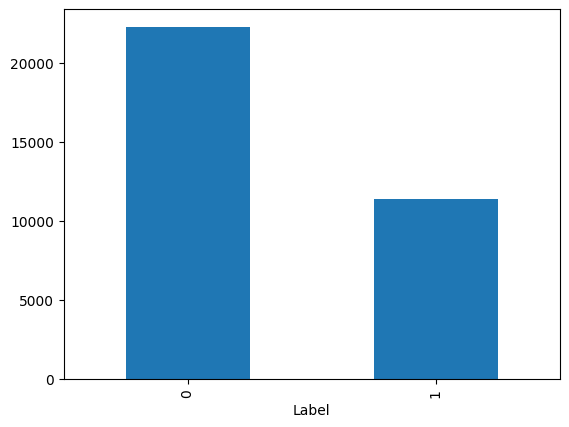

In [ ]:
#using group by command and bar plot
data.groupby('Label')['Sentence'].count().plot.bar()

#printing how many percent of data points belongs to label 1 and label 0
print("Total data points that belongs to label 1 is {} and percent is {}".format(data['Label'].value_counts()[1],round((data['Label'].value_counts()[1] / data.shape[0]) * 100, 2)))
print("Total data points that belongs to label 0 is {} and percent is {}".format(data['Label'].value_counts()[0],round((data['Label'].value_counts()[0] / data.shape[0]) * 100, 2)))


Pengamatan:
- Hanya ada sedikit perbedaan dalam pendistribusiannya

##**3.2.6 plotting wordclouds**

In [ ]:
label_1_text = ""
label_0_text = ""
for i in range(data.shape[0]):
    #fetching the Sentence based on index and convert it to string
    q = str(data['Sentence'].iloc[i])

    #split the queries
    t = q.split()

    if(data['Label'].iloc[i] == 1):
        label_1_text+= " ".join(t) + " "
    else:
        label_0_text+= " ".join(t) + " "


###**3.2.6.1 Plotting wordcloud for label 1 i.e Sql injection queries text**

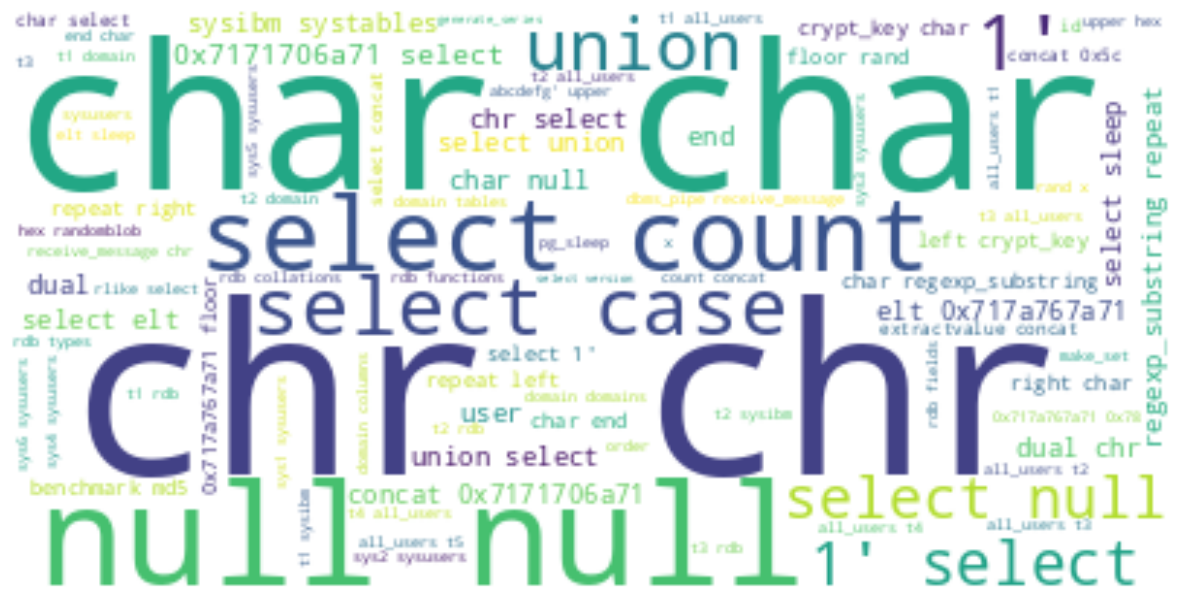

In [ ]:
#plot the worldcloud of label 1 queries
wordcloud = WordCloud(background_color = "white").generate(label_1_text)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

Pengamatan:
- Dalam Label 1 yaitu null, chr, char union, select count case adalah kata-kata yang lebih sering muncul dalam kueri injeksi sql.
- kata-kata yang paling sering muncul ini berguna untuk tujuan rekayasa fitur.

###**3.2.6.2 Plotting wordloud for label 0 i.e Normal sql queries**

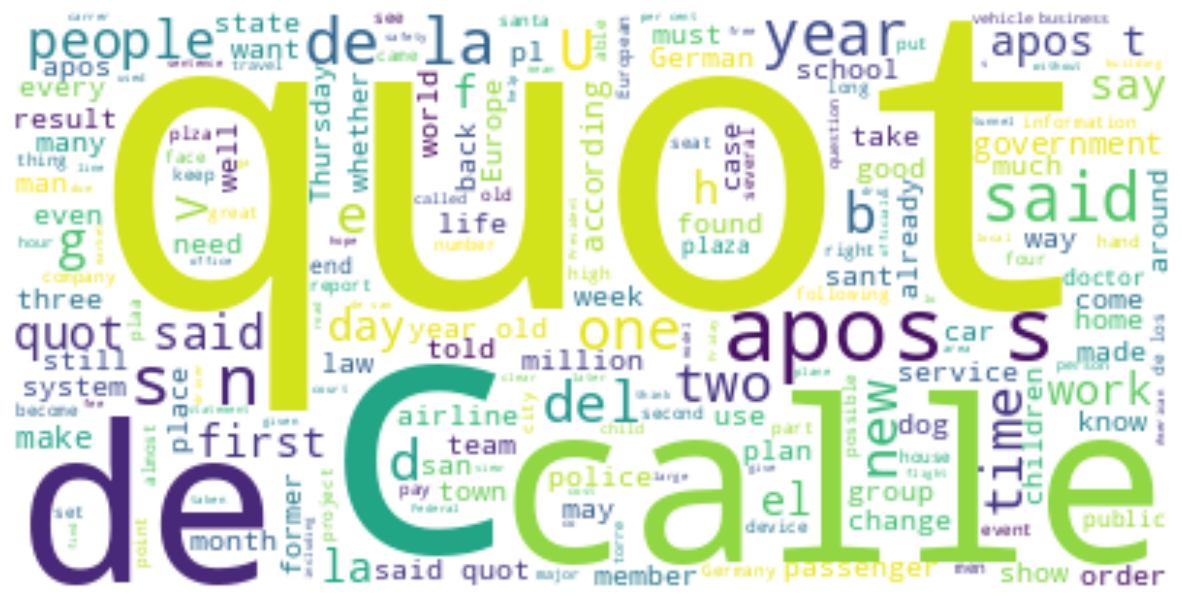

In [ ]:
wordcloud = WordCloud(background_color = "white").generate(label_0_text)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud,interpolation = "bilinear")
plt.axis("off")
plt.show()

#**4. Preprocessing of Text**

- Dari query dataset yang diberikan di atas kita dapat melihat bahwa query tersebut adalah komposisi karakter khusus, tanda baca, dll. Ini semua adalah fitur yang membedakan antara Kalimat sql normal dan Kalimat yang Diinjeksi SQL.
- Tidak akan menghapus tanda baca, tag html, dll sebagai bagian dari pemrosesan awal teks.
- stemming kata dan penghapusan stop word juga tidak dilakukan karena menghilangkan beberapa karakter khusus yang sangat penting untuk rekayasa fitur dan membedakan antara kueri sql dan sqli.
- Jadi pemrosesan awal teks hanya akan mengubah teks menjadi huruf kecil.

##**4.1 Converting Text column values to lowercase**

In [ ]:
def Preprocess(text):

    #converting text to lowercase
    text = str(text).lower()

    return text

#applying above function to queries
data['Sentence'] = data['Sentence'].apply(Preprocess)

In [ ]:
data['Sentence'][1]

'" or pg_sleep ( __time__ ) --'

##**4.2. Feature Extraction**

- Di bawah ini adalah fitur-fitur yang diambil dari tautan yang disebutkan di atas
- Beberapa adalah fitur baru

- Fitur-fiturnya adalah:
    - __Sentence_len__ = panjang setiap Kalimat
    - __num_word_Sentence__ = jumlah total kata dalam sebuah Kalimat.
    - __no_single_qts__ = Jumlah kutipan tunggal dalam sebuah Kalimat
    - __no_double_qts__ = jumlah kutipan ganda dalam sebuah Kalimat.
    - __no_punctn__ = jumlah tanda baca dalam sebuah Kalimat.
    - __no_single_cmnt__ = jumlah komentar satu baris dalam sebuah Kalimat.
    - __no_double_cmnt__ = jumlah komentar baris ganda dalam sebuah Kalimat.
    - __no_white_space__ = jumlah spasi dalam sebuah Kalimat.
    - __no_percent__ = jumlah simbol persentase.
    - __no_log_optr__ = jumlah total operator logika dalam sebuah Kalimat.
    - __no_arith_oprtr__ = jumlah total operator aritmatika.
    - __no_null_val__ = jumlah total nilai null dalam sebuah Kalimat.
    - __no_hexdec_val__ = jumlah total nilai desimal heksa.
    - __no_alphabet__ = jumlah total huruf dalam sebuah Kalimat.
    - __no_digits__ = jumlah total digit.
    - __len_of_chr_char_null__ = panjang kata kunci chr + char + null fitur ini didasarkan pada wordcloud di atas.
    - __genuine_keywords__ = kata kunci ini juga dihasilkan menggunakan wordclouds untuk teks kelas label 0 kata kunci ini mencakup pilih, atas, pesan, ambil, gabung, rata-rata, hitung, jumlah, baris.

###**4.2.1 Creating the above mentioned features and adding it to dataframe**

In [ ]:
import re  # Mengimpor modul regex untuk pencarian pola dalam teks

# Menghitung panjang setiap kalimat dalam kolom 'Sentence'
data['Sentence_len'] = data['Sentence'].apply(lambda x: len(x))

# Menghitung jumlah kata dalam setiap kalimat dalam kolom 'Sentence'
data['num_words_Sentence'] = data['Sentence'].apply(lambda x: len(x.split()))

# Menghitung jumlah tanda kutip tunggal dalam setiap kalimat
def single_qt(x):
    r = re.compile(r"'")
    l = r.findall(x)
    return len(l)
data['no_single_qts'] = data['Sentence'].apply(single_qt)

# Menghitung jumlah tanda kutip ganda dalam setiap kalimat
def double_qt(x):
    r = re.compile(r'"')
    l = r.findall(x)
    return len(l)
data['no_double_qts'] = data['Sentence'].apply(double_qt)

# Menghitung jumlah tanda baca dalam setiap kalimat
def punctuation(x):
    r = re.compile("[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]")
    l = r.findall(x)
    return len(l)
data['no_punct'] = data['Sentence'].apply(punctuation)

# Menghitung jumlah komentar satu baris dalam setiap kalimat
def sin_comm(x):
    r = re.compile(r'(--)')
    l = r.findall(x)
    return len(l)
data['no_single_cmnt'] = data['Sentence'].apply(sin_comm)

# Menghitung jumlah komentar multibaris dalam setiap kalimat
def mult_comm(x):
    r = re.compile(r'(\/\*)')
    l = r.findall(x)
    return len(l)
data['no_mult_cmnt'] = data['Sentence'].apply(mult_comm)

# Menghitung jumlah spasi dalam setiap kalimat
def space(x):
    r = re.compile(r'\s+')
    l = r.findall(x)
    return len(l)
data['no_space'] = data['Sentence'].apply(space)

# Menghitung jumlah simbol persentase (%) dalam setiap kalimat
def perc(x):
    r = re.compile(r'%')
    l = r.findall(x)
    return len(l)
data['no_perc'] = data['Sentence'].apply(perc)

# Menghitung jumlah operator logika dalam setiap kalimat
def logical(x):
    r = re.compile(r'\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!')
    l = r.findall(x)
    return len(l)
data['no_log_opt'] = data['Sentence'].apply(logical)

# Menghitung jumlah operator aritmatika dalam setiap kalimat
def arithmetic(x):
    r = re.compile(r'\+|-|[^\/]\*|\/[^\*]')
    l = r.findall(x)
    return len(l)
data['no_arith'] = data['Sentence'].apply(arithmetic)

# Menghitung jumlah kata "null" dalam setiap kalimat
def null_val(x):
    r = re.compile(r'null')
    l = r.findall(x)
    return len(l)
data['no_null'] = data['Sentence'].apply(null_val)

# Menghitung jumlah nilai heksadesimal dalam setiap kalimat
def hexa(x):
    r = re.compile(r'0[xX][0-9a-fA-F]+\s')
    l = r.findall(x)
    return len(l)
data['no_hexa'] = data['Sentence'].apply(hexa)

# Menghitung jumlah huruf dalam setiap kalimat
def alphabet(x):
    r = re.compile(r'[a-zA-Z]')
    l = r.findall(x)
    return len(l)
data['no_alpha'] = data['Sentence'].apply(alphabet)

# Menghitung jumlah digit dalam setiap kalimat
def digit(x):
    r = re.compile(r'[0-9]')
    l = r.findall(x)
    return len(l)
data['no_digit'] = data['Sentence'].apply(digit)

# Menghitung panjang kata kunci gabungan seperti "chr", "char", dan "null"
def combined_keywords(x):
    r = re.compile(r'null')
    m = re.compile(r'chr')
    n = re.compile(r'char')
    l = r.findall(x)
    k = m.findall(x)
    j = n.findall(x)
    return len(l) + len(k) + len(j)
data['len_of_chr_char_null'] = data['Sentence'].apply(combined_keywords)

# Menghitung jumlah kata kunci asli yang terdaftar dalam 'genuine_keys' dalam setiap kalimat
def genuine(x):
    count = 0
    genuine_keys = ['calle', 'apos', 'quot', 'said', 'people', 'time', 'change', 'people', 'year']
    for i in x.split():
        if(i in genuine_keys):
            count = count + 1
    return count

data['genuine_keywords'] = data['Sentence'].apply(genuine)

In [ ]:
data['Sentence'][4]

"' and 1 = utl_inaddr.get_host_address  (  (  select distinct ( table_name )  from  ( select distinct ( table_name ) , rownum as limit from sys.all_tables )  where limit = 5  )  )   and 'i' = 'i"

In [ ]:
data.head(10)

Sentence  Label  Sentence_len  \
1                       " or pg_sleep ( __time__ ) --      1            29   
2   create user name identified by pass123 tempora...      1            91   
3                                                 %29      1             3   
4   ' and 1 = utl_inaddr.get_host_address  (  (  s...      1           193   
5    select * from users where id = '1' or @ @1 = ...      1            82   
6    select * from users where id = 1 or 1#" (  un...      1            77   
7   ' select name from syscolumns where id  =   ( ...      1           102   
8    select * from users where id = 1 +$+ or 1 = 1...      1            51   
9   1; ( load_file ( char ( 47,101,116,99,47,112,9...      1            81   
10   select * from users where id = '1' or ||/1 = ...      1            82   

    num_words_Sentence  no_single_qts  no_double_qts  no_punct  \
1                    7              0              1        10   
2                   12              0              0         1   
3                    1              0              0         1   
4                   36              4              0        26   
5                   20              3              0        13   
6                   18              0              1        10   
7                   19              2              0         8   
8                   15              0              0         8   
9                   11              0              0        22   
10                  19              3              0        14   

    no_single_cmnt  no_mult_cmnt  no_space  no_perc  no_log_opt  no_arith  \
1                1             0         6        0           1         2   
2                0             0        12        0           0         0   
3                0             0         0        1           0         0   
4                0             0        35        0           2         0   
5                1             0        20        0           1         3   
6                1             0        18        0           1         3   
7                1             0        18        0           0         2   
8                1             0        15        0           1         5   
9                0             0        10        0           0         0   
10               1             0        19        0           2         4   

    no_null  no_hexa  no_alpha  no_digit  len_of_chr_char_null  \
1         0        0        13         0                     0   
2         0        0        75         3                     0   
3         0        0         0         2                     0   
4         0        0       120         2                     0   
5         0        0        42         5                     0   
6         0        0        42         4                     0   
7         0        0        71         0                     0   
8         0        0        24         4                     0   
9         0        0        12        33                     1   
10        0        0        42         5                     0   

    genuine_keywords  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
6                  0  
7                  0  
8                  0  
9                  0  
10                 0

##**4.3 Analysis of extracted features**

##**4.3.1 Sentence_len : Length of each Sentence**

In [ ]:
#Sentence_len
data['Sentence_len'].describe()

count    33723.000000
mean        49.617828
std         71.704967
min          1.000000
25%          8.000000
50%         19.000000
75%         67.000000
max       5316.000000
Name: Sentence_len, dtype: float64

Pengamatan :
- Panjang Minimal Kalimat adalah 1.
- panjang maksimum sebuah Kalimat adalah 5316. dan panjang rata-rata adalah 49.

##**4.3.2 Feature vs output classes plots**

###**4.3.2.1 Violin plot : Sentence_length vs Labels**

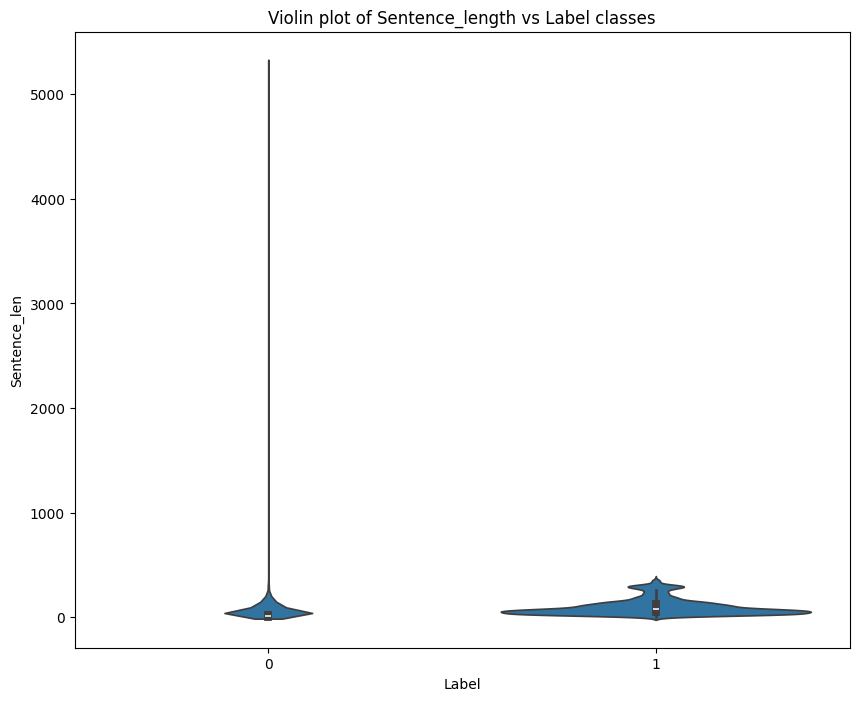

In [ ]:
#fitur vs output plot
#akan memeriksa apakah fitur tersebut membantu dalam memprediksi label keluaran
#akan membuat plot violin dan plot distribusi
#analisis univariat

#violin plots
plt.figure(figsize = (10,8))


sns.violinplot(x = data['Label'],y = data['Sentence_len'],data=data)
plt.title("Violin plot of Sentence_length vs Label classes")

plt.show()

###**4.3.2.2 Distribution of Sentence_length vs labels**

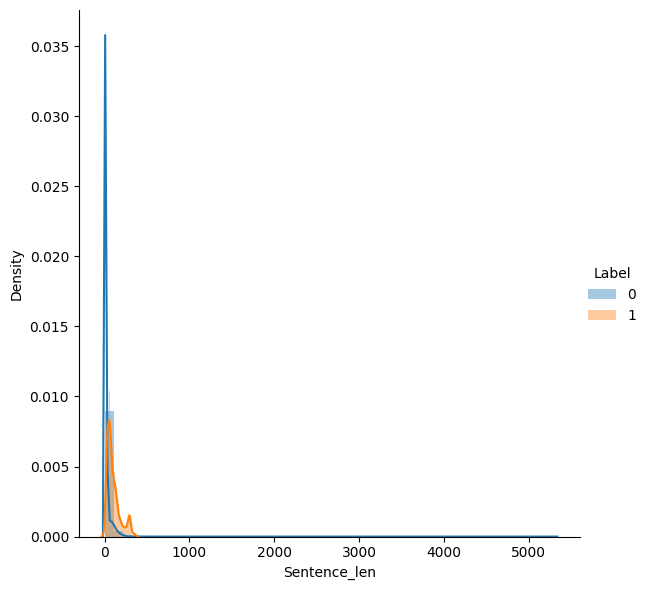

In [ ]:
#checking the distribution
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "Sentence_len") \
   .add_legend()

plt.show()

Pengamatan:
- Terdapat lebih banyak tumpang tindih antara label 1 dan label 0 Panjang kalimat.
- Sulit untuk membedakan antara kueri injeksi sql dan sql

###**4.3.2.3 Applying transformations**

- Distribusi di atas terlihat seperti distribusi lognormal. Kami akan menerapkan dua transformasi untuk melihat bahwa keduanya dapat dikonversi ke distribusi guassian tidak.
            - Logarithmic transformations.
            - Box cox transformations.

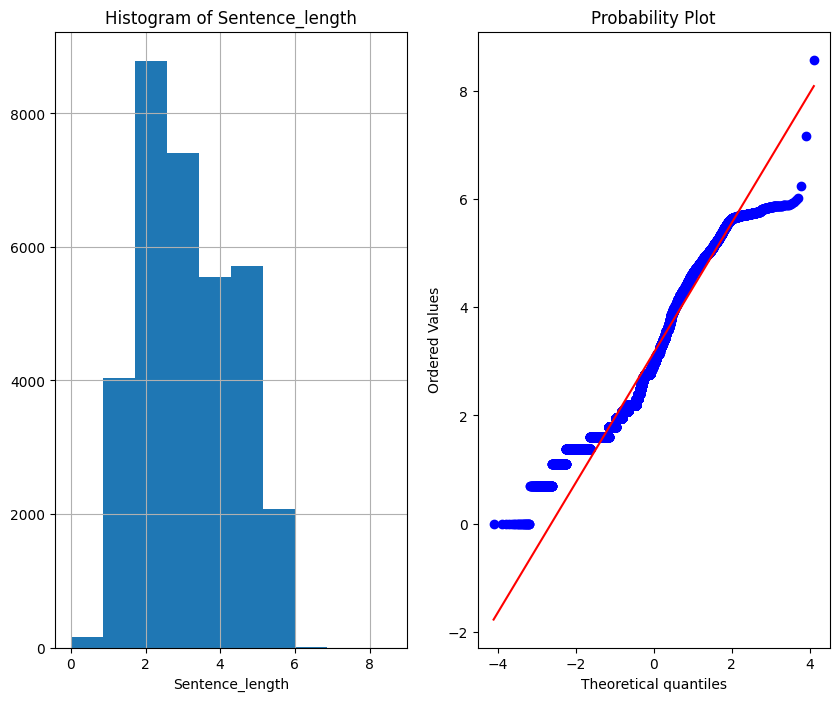

In [ ]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['Sentence_len']).hist()
plt.xlabel('Sentence_length')
plt.title("Histogram of Sentence_length")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['Sentence_len']),dist = 'norm',plot = plt)
plt.show()


Pengamatan :
- Setelah menerapkan transformasi logaritmik dengan melihat histogram, terlihat seperti distribusi guassian tetapi kami mengonfirmasinya menggunakan plot QQ.
- Dengan melihat plot Q-Q belum sepenuhnya terdistribusi guassian. beberapa titik di kiri dan kanan miring.

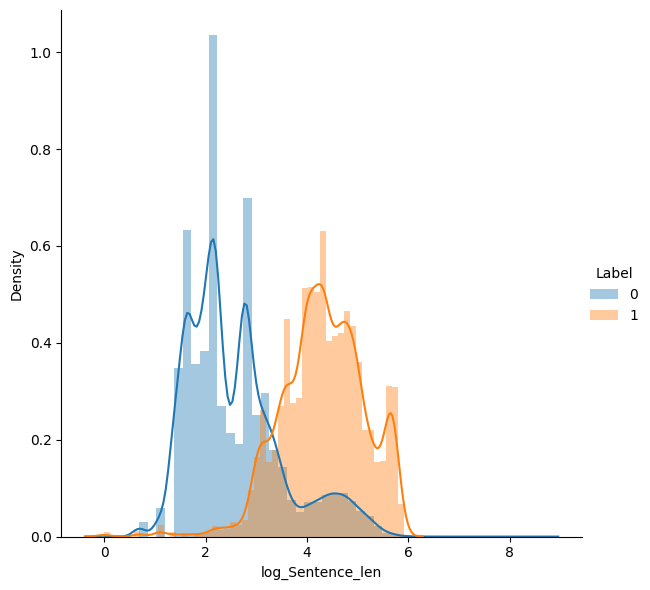

In [ ]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_Sentence_len'] = data['Sentence_len'].apply(lambda x : np.log(x))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_Sentence_len") \
   .add_legend()

plt.show()

-Distribusi di atas menunjukkan Ada sedikit tumpang tindih antara kelas label sehingga kami menghindari penggunaan nilai transformasi log untuk pembuatan Model

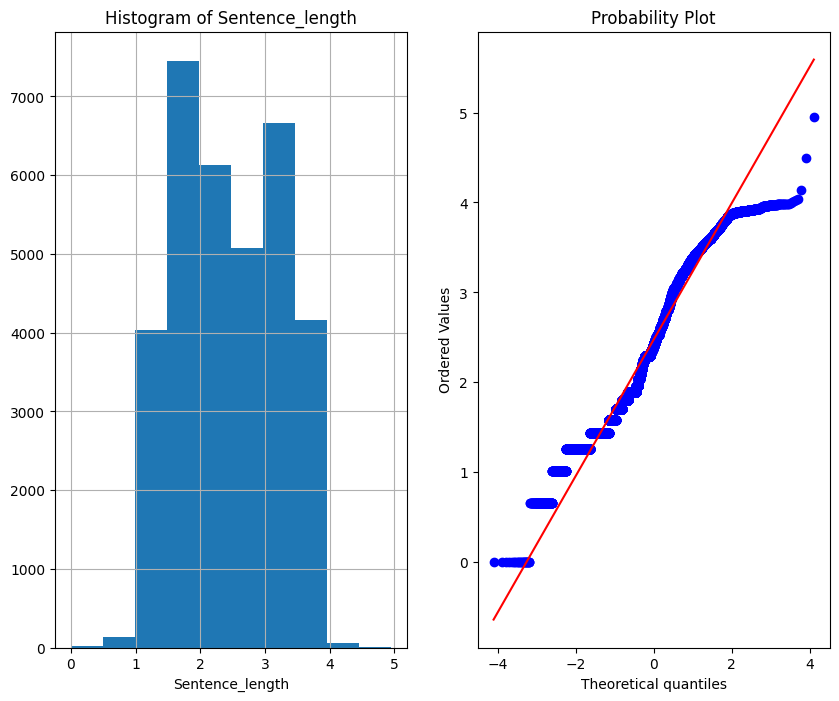

In [ ]:
#box-cox transformations
x,lamb = boxcox(data['Sentence_len'],lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('Sentence_length')
plt.title("Histogram of Sentence_length")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()

Dari transformasi box-cox di atas kita dapat mengamati bahwa distribusi Guassian tidak sempurna

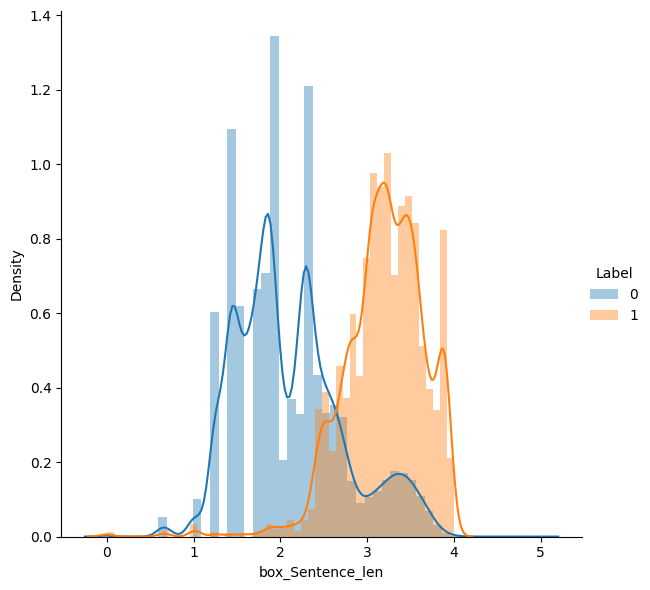

In [ ]:
#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_Sentence_len'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_Sentence_len") \
   .add_legend()

plt.show()

- Nilai transformasi box cox juga memiliki sedikit tumpang tindih sehingga kami menghindari penggunaan nilai ini untuk pembuatan model

###**4.3.2.4 num_words_Sentence : Number of words in a Sentence**

In [ ]:
#num_words_Sentence
data['num_words_Sentence'].describe()

count    33723.000000
mean         9.572458
std         15.329373
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max        216.000000
Name: num_words_Sentence, dtype: float64

Pengamatan:
- Nilai minimum kata adalah 1
- nilai maksimum dan mean adalah 216 dan 9

###**4.3.2.5 Filtering out the queries which have zero words and removing them from datset**

In [ ]:
#dari statistik di atas kita dapat melihat bahwa jumlah minimum kata yang ditemukan adalah nol jadi tidak boleh nol.
#akan menemukan Kalimat yang num_word_Sentence-nya nol
#num_kata_Kalimat

data[data['num_words_Sentence'] == 0]

Empty DataFrame
Columns: [Sentence, Label, Sentence_len, num_words_Sentence, no_single_qts, no_double_qts, no_punct, no_single_cmnt, no_mult_cmnt, no_space, no_perc, no_log_opt, no_arith, no_null, no_hexa, no_alpha, no_digit, len_of_chr_char_null, genuine_keywords, log_Sentence_len, box_Sentence_len]
Index: []

[0 rows x 21 columns]

In [ ]:
data.head()

Sentence  Label  Sentence_len  \
1                      " or pg_sleep ( __time__ ) --      1            29   
2  create user name identified by pass123 tempora...      1            91   
3                                                %29      1             3   
4  ' and 1 = utl_inaddr.get_host_address  (  (  s...      1           193   
5   select * from users where id = '1' or @ @1 = ...      1            82   

   num_words_Sentence  no_single_qts  no_double_qts  no_punct  no_single_cmnt  \
1                   7              0              1        10               1   
2                  12              0              0         1               0   
3                   1              0              0         1               0   
4                  36              4              0        26               0   
5                  20              3              0        13               1   

   no_mult_cmnt  no_space  ...  no_log_opt  no_arith  no_null  no_hexa  \
1             0         6  ...           1         2        0        0   
2             0        12  ...           0         0        0        0   
3             0         0  ...           0         0        0        0   
4             0        35  ...           2         0        0        0   
5             0        20  ...           1         3        0        0   

   no_alpha  no_digit  len_of_chr_char_null  genuine_keywords  \
1        13         0                     0                 0   
2        75         3                     0                 0   
3         0         2                     0                 0   
4       120         2                     0                 0   
5        42         5                     0                 0   

   log_Sentence_len  box_Sentence_len  
1          3.367296          2.674687  
2          4.510860          3.327873  
3          1.098612          1.016958  
4          5.262690          3.702839  
5          4.406719          3.272695  

[5 rows x 21 columns]

In [ ]:
data.shape

(33723, 21)

In [ ]:
data['num_words_Sentence'].describe()

count    33723.000000
mean         9.572458
std         15.329373
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max        216.000000
Name: num_words_Sentence, dtype: float64

###**4.3.2.6  Violin plot: Number of words in a Sentence vs Labels**

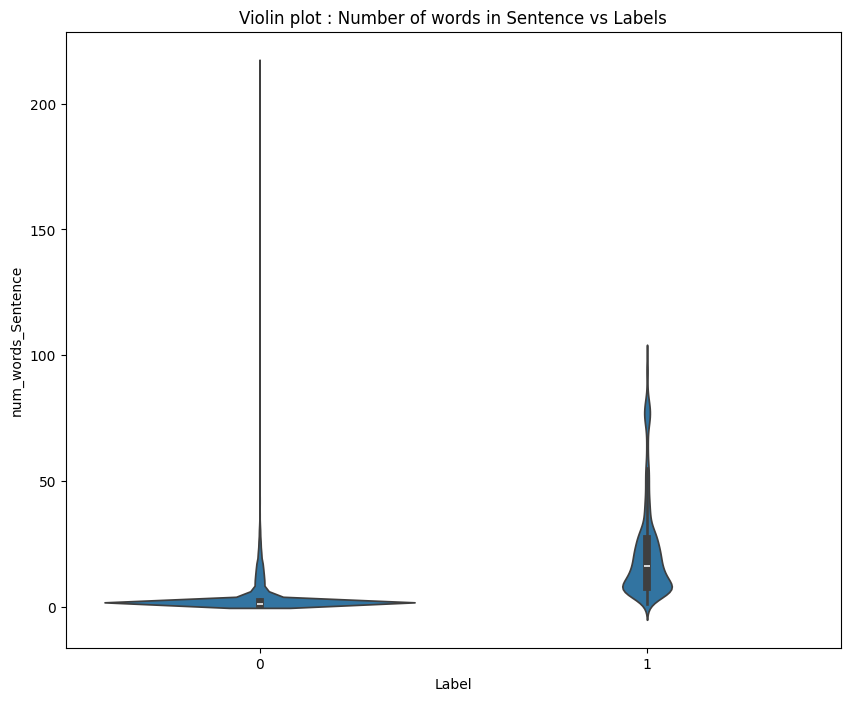

In [ ]:
#num_words_Sentence\
#number of words in a Sentence
#violin plots
plt.figure(figsize = (10,8))


sns.violinplot(x = data['Label'],y = data['num_words_Sentence'],data=data)

plt.title("Violin plot : Number of words in Sentence vs Labels")
plt.show()

###**4.3.2.7 Distribution plot of number of words in a Sentence**

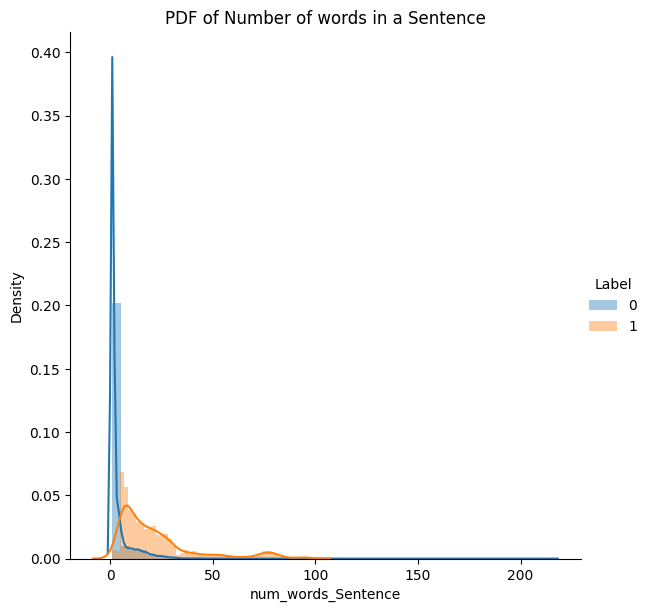

In [ ]:
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "num_words_Sentence") \
   .add_legend()

plt.title("PDF of Number of words in a Sentence")
plt.show()

Pengamatan:
- Distribusinya menunjukkan adanya tumpang tindih antar label.
- Jika jumlah kata > 50 kita dapat mengatakan itu adalah Kalimat sqli tetapi tidak sempurna.

###**4.3.2.8 Applying Transformations**

- Distribusi di atas sepertinya Distribusi log normal akan memeriksa apakah kita dapat mengubahnya menjadi distribusi guassian. Dengan menerapkan
   - Transformasi logratmik.
   - Transformasi kotak cox.

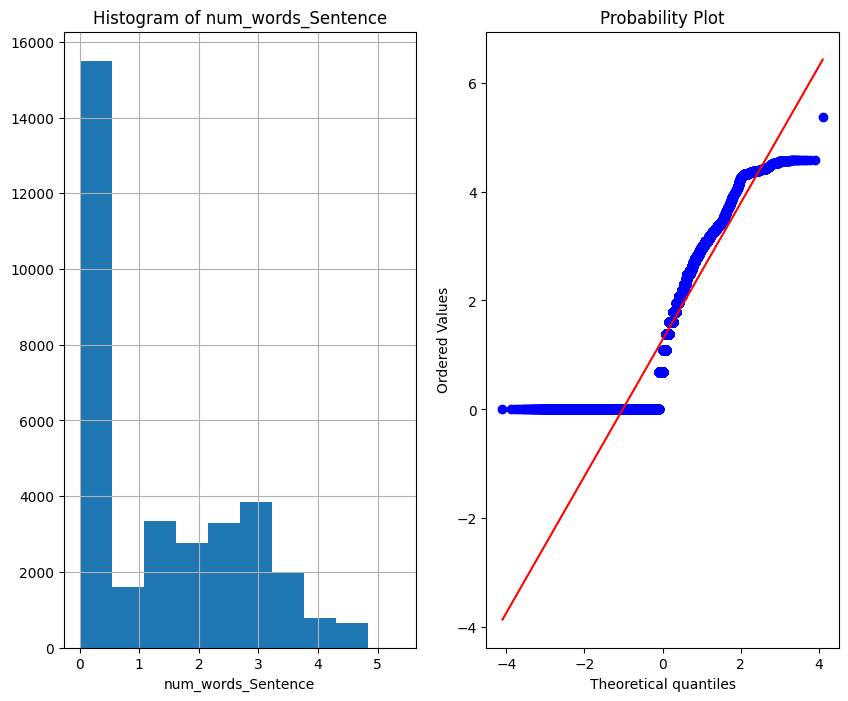

In [ ]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['num_words_Sentence']).hist()
plt.xlabel('num_words_Sentence')
plt.title("Histogram of num_words_Sentence")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['num_words_Sentence']),dist = 'norm',plot = plt)
plt.show()

Pengamatan -
- Histogramnya lebih miring ke kanan dan tidak terlihat seperti distribusi guassian yang sempurna.

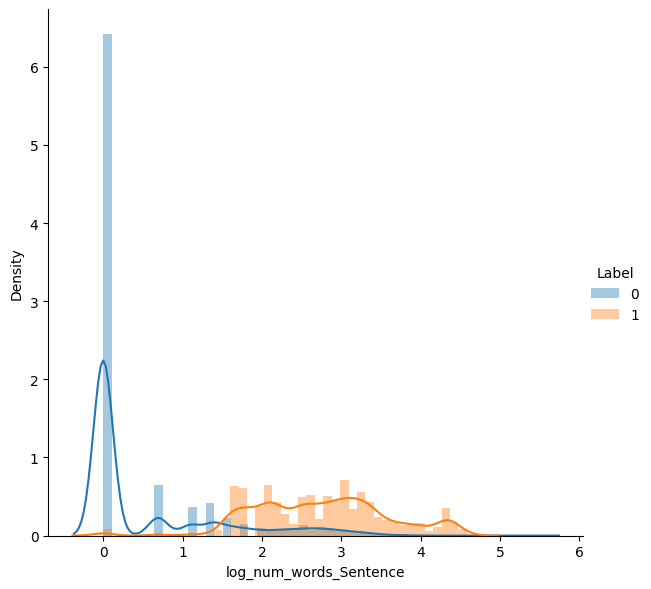

In [ ]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_num_words_Sentence'] = data['num_words_Sentence'].apply(lambda x : np.log(x))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_num_words_Sentence") \
   .add_legend()

plt.show()

-Distribusi menunjukkan adanya tumpang tindih yang tinggi antara kelas label sehingga kami menghindari mengambil nilai-nilai ini

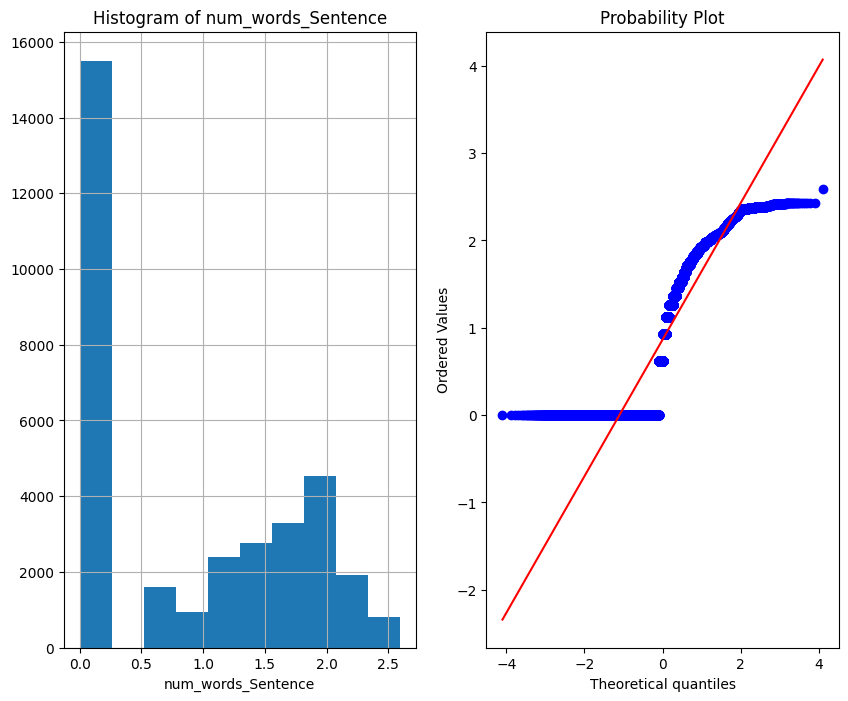

In [ ]:
#box-cox transformations
x,lamb = boxcox(data['num_words_Sentence'],lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('num_words_Sentence')
plt.title("Histogram of num_words_Sentence")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()

Distribusinya terlihat sama dengan distribusi transformasi lograthmic di atas.

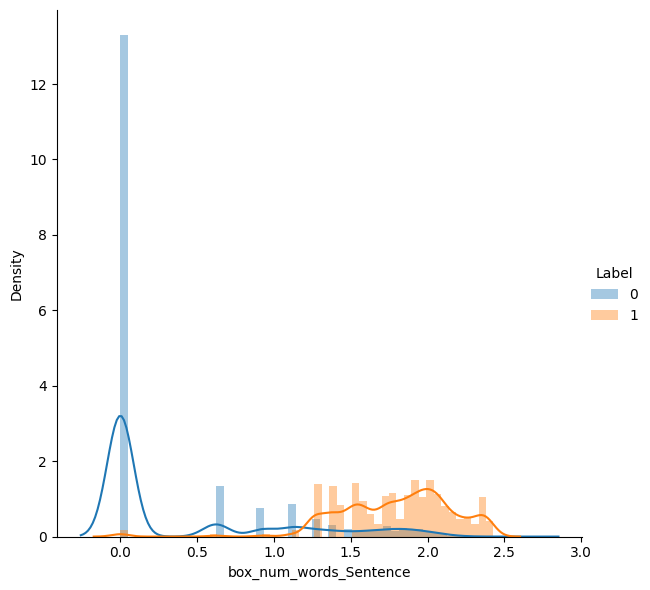

In [ ]:
#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_num_words_Sentence'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_num_words_Sentence") \
   .add_legend()

plt.show()

- Sama halnya, ada tumpang tindih yang tinggi antar kelas sehingga kami menghindari mengambil nilai-nilai ini

###**4.3.3 no_single_qts : number of single quotations in a Sentence**

In [ ]:
data['no_single_qts'] .describe()

count    33723.000000
mean         0.385286
std          1.062751
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: no_single_qts, dtype: float64

Pengamatan :
- Ada query yang tidak memiliki tanda kutip tunggal sama sekali sehingga minimalnya nol dan maksimal tanda kutip tunggal dalam sebuah Kalimat adalah 8

###**4.3.3.1 Violin plot : num_single_qts vs labels**

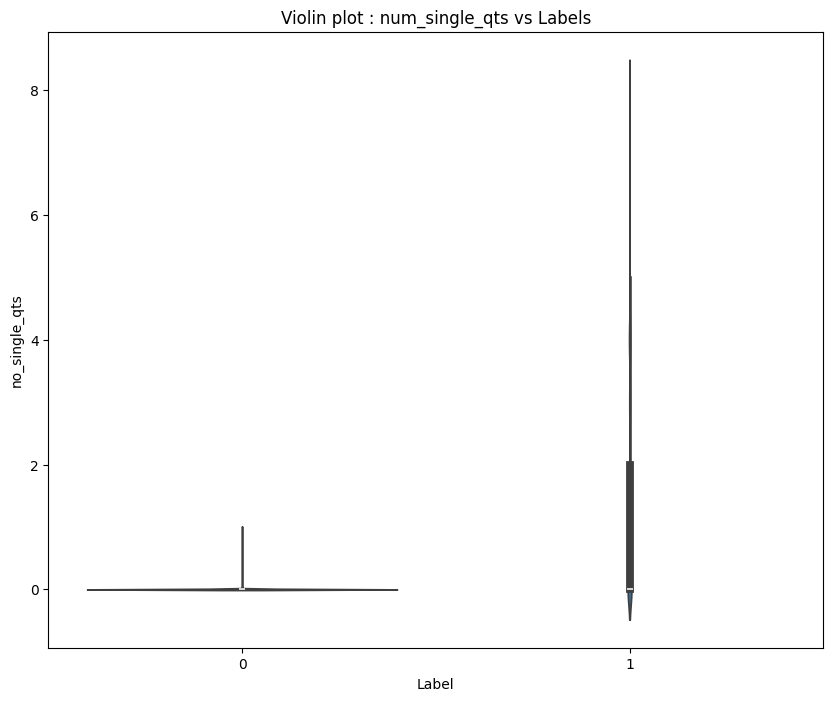

In [ ]:
#no_single_qts
#number of single quotation.

plt.figure(figsize = (10,8))

sns.violinplot(x = data['Label'],y = data['no_single_qts'],data=data)

plt.title("Violin plot : num_single_qts vs Labels")
plt.show()


Pengamatan:
- Nilai persentil label 0 tidak terlihat akan diperiksa lebih lanjut dengan memplot boxplot.

###**4.3.3.2 Box plot of num_single_qts vs labels**

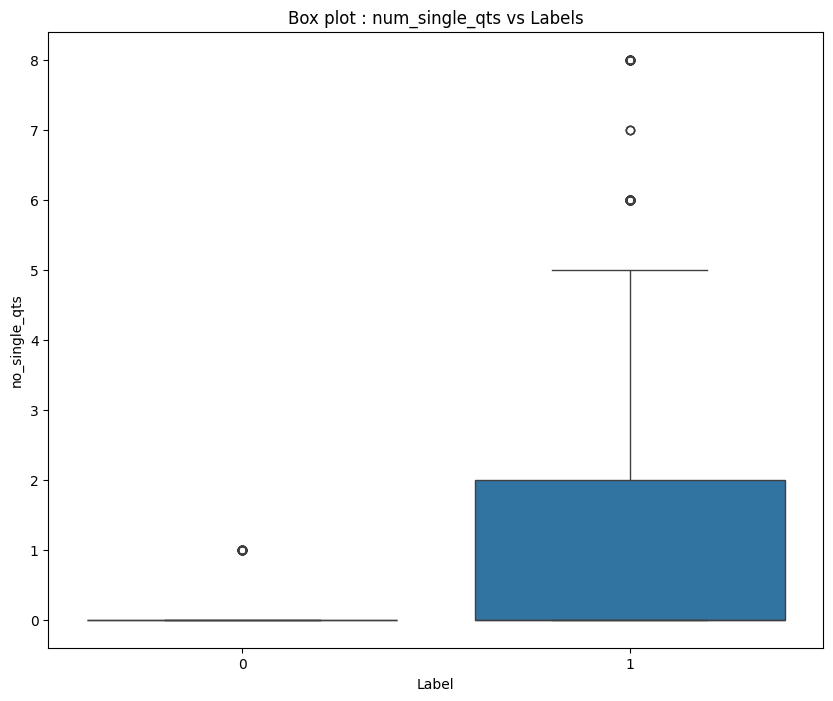

In [ ]:
plt.figure(figsize = (10,8))

sns.boxplot(x = data['Label'],y = data['no_single_qts'],data=data)

plt.title("Box plot : num_single_qts vs Labels")
plt.show()

Pengamatan:
- Kami dapat mengonfirmasi bahwa nilai pernetile 25,50 dan 75 dari label 0. yaitu kueri sql adalah 0. artinya kueri sql memiliki tanda kutip tunggal yang lebih sedikit dibandingkan kueri injeksi sql.
- Fitur ini akan membantu membedakan antara nilai label 0 dan label 1 karena tidak ada banyak tumpang tindih di antara keduanya.


###**4.3.3.3 Distribution of num_single_qts**

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

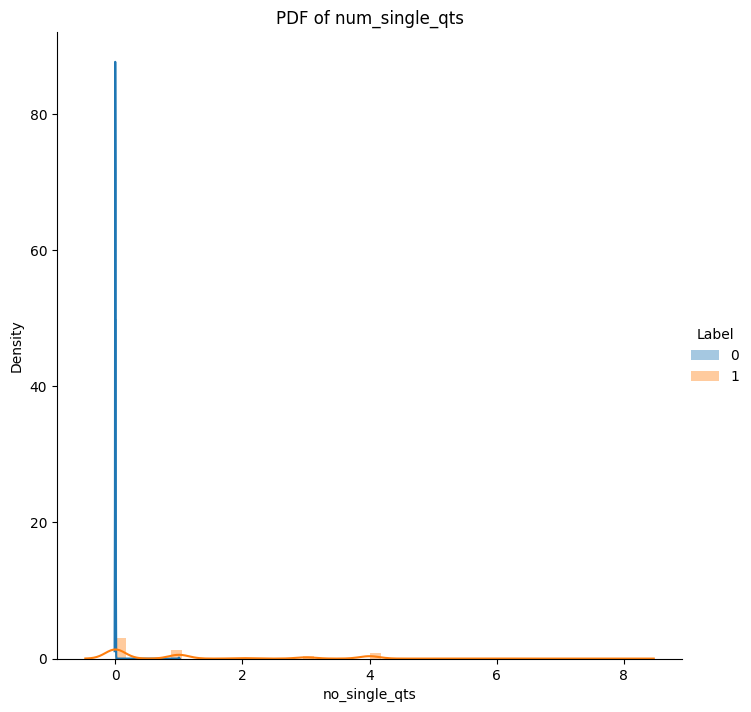

In [ ]:
import seaborn as sns
#plotting pdf
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_single_qts",kde_kws = {'bw' : 0.1}) \
   .add_legend()
plt.title("PDF of num_single_qts")
plt.show()

Pengamatan :
- Kita dapat melihat ketika jumlah kutipan tunggal adalah 1 dan 3 maka querynya adalah injeksi sql.
- ketika jumlah kutipan tunggal adalah 6 atau sekitar 12, kueri tersebut adalah kueri sql normal atau asli.
- ada sedikit tumpang tindih.
- kita bisa menulis model berbasis aturan seperti ini:


                          if(no_single_qts == 1 and no_single_qts == 3):
                                 then it is label 1 i.e sql injection Sentence.
                          else if(no_single_qts == 6 and no_single_qts == 12):
                                 then it is label 0 i.e sql Sentence.

###**4.3.3.4 no_double_qts : Number of double quotations in a Sentence**

In [ ]:
#no_double_qts
#number of double quotes in a Sentence

data['no_double_qts'].describe()

count    33723.000000
mean         0.206802
std          0.767261
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: no_double_qts, dtype: float64

Double quotes lies in range of 0 to 20

###**4.3.3.5 Countplot of num_double_qts va Labels**

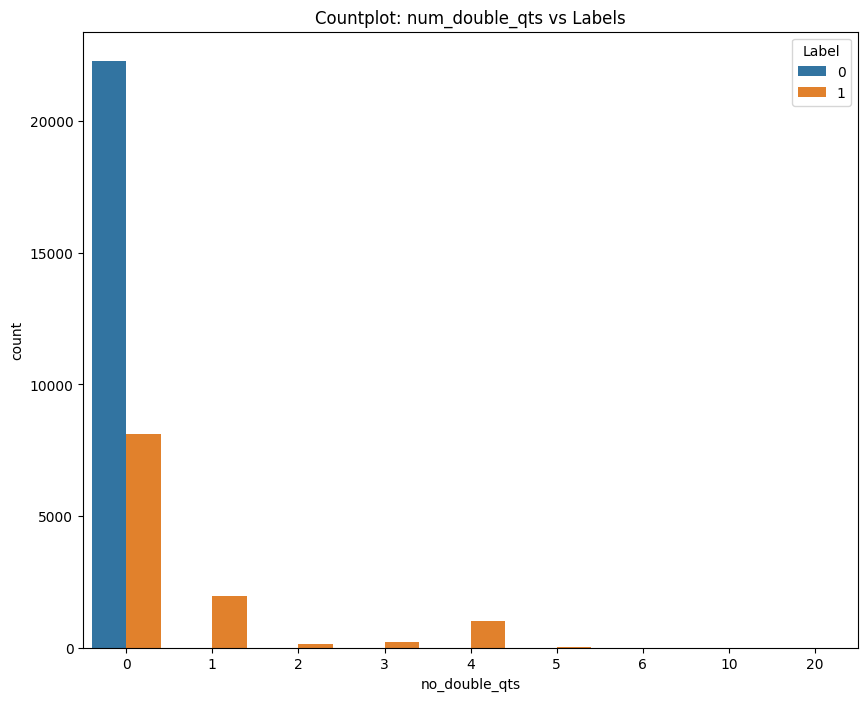

In [ ]:
plt.figure(figsize = (10,8))

sns.countplot(x = data['no_double_qts'],hue = data['Label'],data=data)

plt.title("Countplot: num_double_qts vs Labels")
plt.show()

Pengamatan :
- jumlah kueri maksimum tidak memiliki tanda kutip ganda.
- jika jumlah kueri adalah 1 dan 3 maka kemungkinan besar itu adalah Kalimat injeksi sql.

###**4.3.3.6 Box plot : num_double_qts vs Labels**

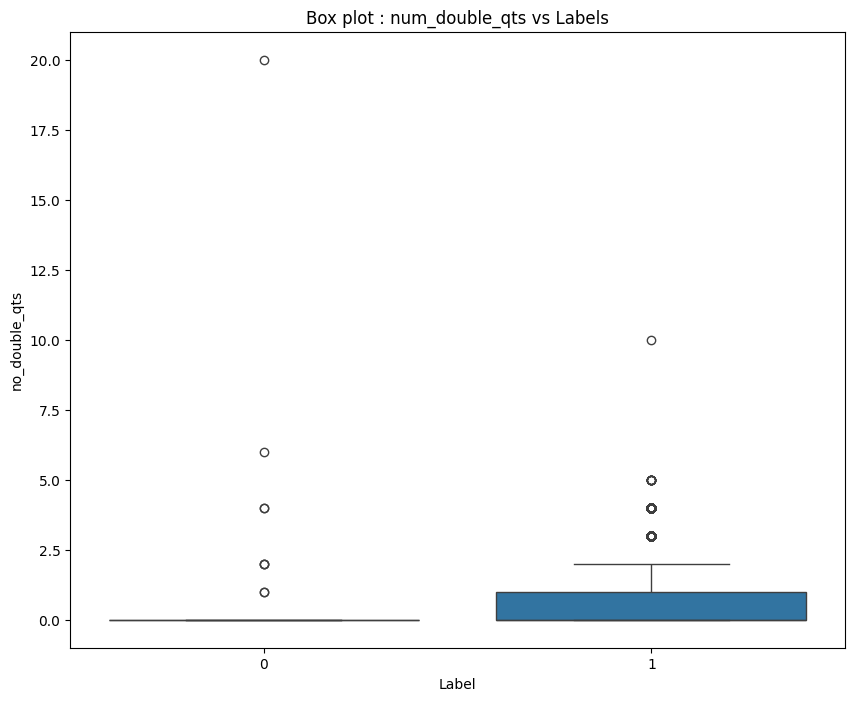

In [ ]:
plt.figure(figsize = (10,8))

sns.boxplot(x = data['Label'],y = data['no_double_qts'],data=data)

plt.title("Box plot : num_double_qts vs Labels")
plt.show()

###**4.3.3.7 no_punct : Number of punctuations in a Sentence**

In [ ]:
#no_punct
data['no_punct'].describe()

count    33723.000000
mean         6.164131
std         12.678349
min          0.000000
25%          0.000000
50%          1.000000
75%          7.000000
max        674.000000
Name: no_punct, dtype: float64

###**4.3.3.8 count plot : no_punct vs labels**

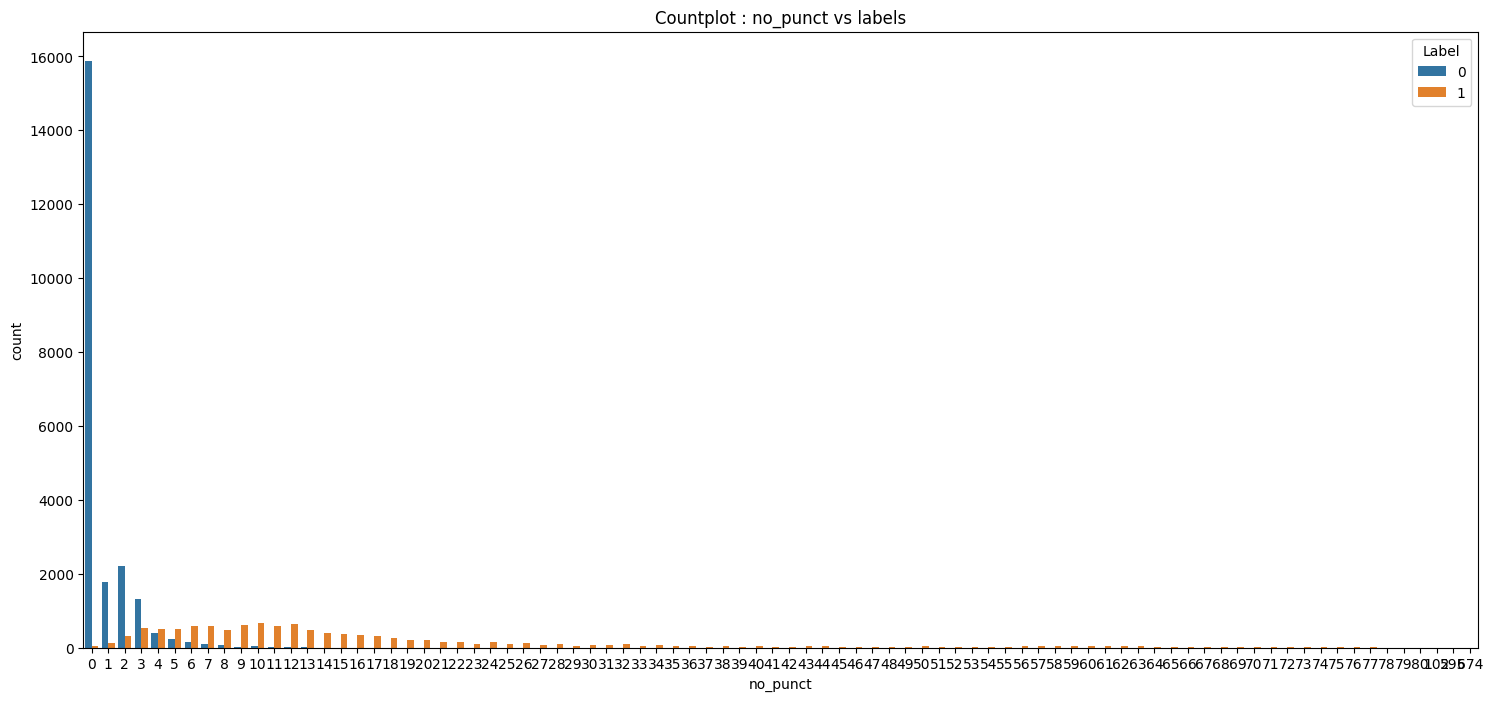

In [ ]:
#no_punct
#number of punctuations in a Sentence.

plt.figure(figsize = (18,8))

sns.countplot(x = data['no_punct'],hue = data['Label'],data=data)

plt.title("Countplot : no_punct vs labels")
plt.show()

Pengamatan :
- Sebagian besar pertanyaan tidak memiliki tanda baca sama sekali
- ada sedikit tumpang tindih hingga jumlah tanda baca menjadi 16 atau 17. setelah itu seiring bertambahnya tanda baca, kemungkinan besar itu adalah Kalimat injeksi sql.

###**4.3.3.9 no_single_cmnt : Number of single line comment in a Sentence**

In [ ]:
#no_single_cmnt
#number of single comments
data['no_single_cmnt'].describe()

count    33723.00000
mean         0.12573
std          1.27943
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max        227.00000
Name: no_single_cmnt, dtype: float64

###**4.3.3.10 Countplot : no_single_cmnt vs labels**

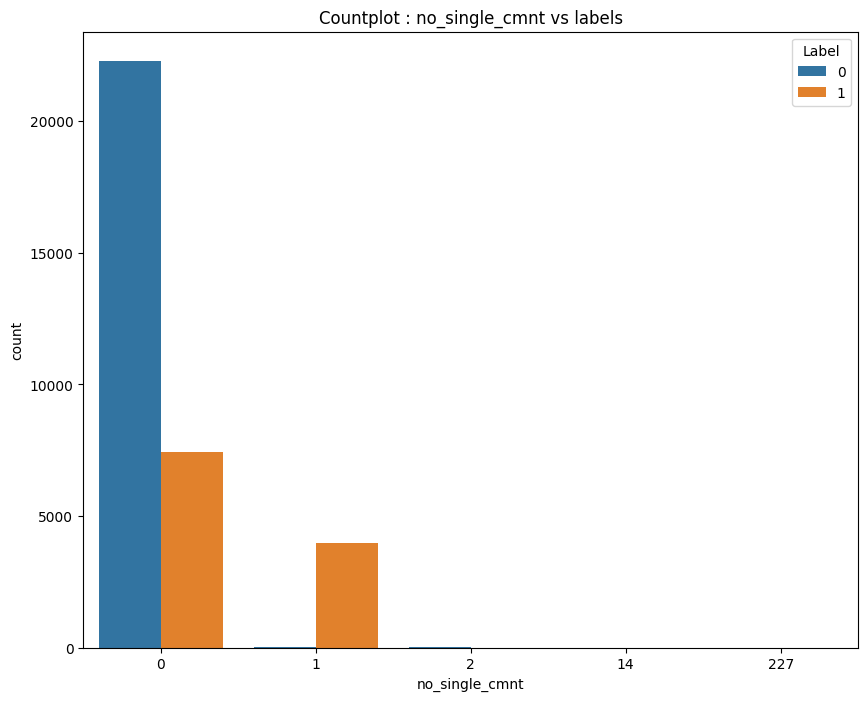

In [ ]:
plt.figure(figsize = (10,8))

sns.countplot(x = data['no_single_cmnt'],hue = data['Label'],data=data)

plt.title("Countplot : no_single_cmnt vs labels")
plt.show()

Pengamatan:
- Sangat jelas dari plot di atas jika jumlah komentar tunggal adalah 1 maka itu adalah Kalimat injeksi sql.
- kita dapat menulis model dasar aturan seperti ini:
                 if(no_single_cmnt == 1):
                      then label 1
                 else:
                      label 0

###**4.3.3.11 no_mult_cmnt : Number of multi line comment in a Sentence**

In [ ]:
#no_mult_cmnt
#number of multiline comments
data['no_mult_cmnt'].describe()

count    33723.000000
mean         0.000919
std          0.041103
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: no_mult_cmnt, dtype: float64

###**4.3.3.12 count plot :  no_mult_cmnt vs labels**

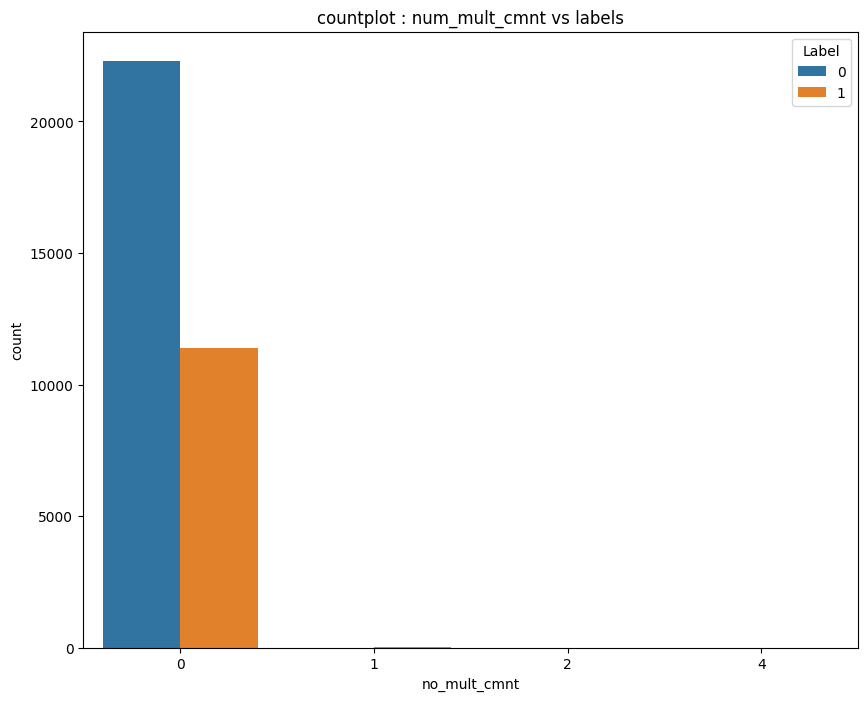

In [ ]:
plt.figure(figsize = (10,8))

sns.countplot(x=data['no_mult_cmnt'],hue = data['Label'],data=data)

plt.title("countplot : num_mult_cmnt vs labels")
plt.show()

Pengamatan:
- sebagian besar kueri tidak memiliki komentar multi-baris dan sangat sedikit jumlah kueri yang memiliki komentar multi-baris. Jika sebuah Kalimat memiliki komentar multi-baris maka itu adalah Kalimat injeksi sql.

###**4.3.3.13 no_space : number of white spaces in a Sentence**

In [ ]:
#no_space
#number of white space in Sentence
data['no_space'].describe()

count    33723.000000
mean         8.772826
std         15.416720
min          0.000000
25%          0.000000
50%          1.000000
75%         12.000000
max        215.000000
Name: no_space, dtype: float64

###**4.3.3.13.1 no_space vs labels**

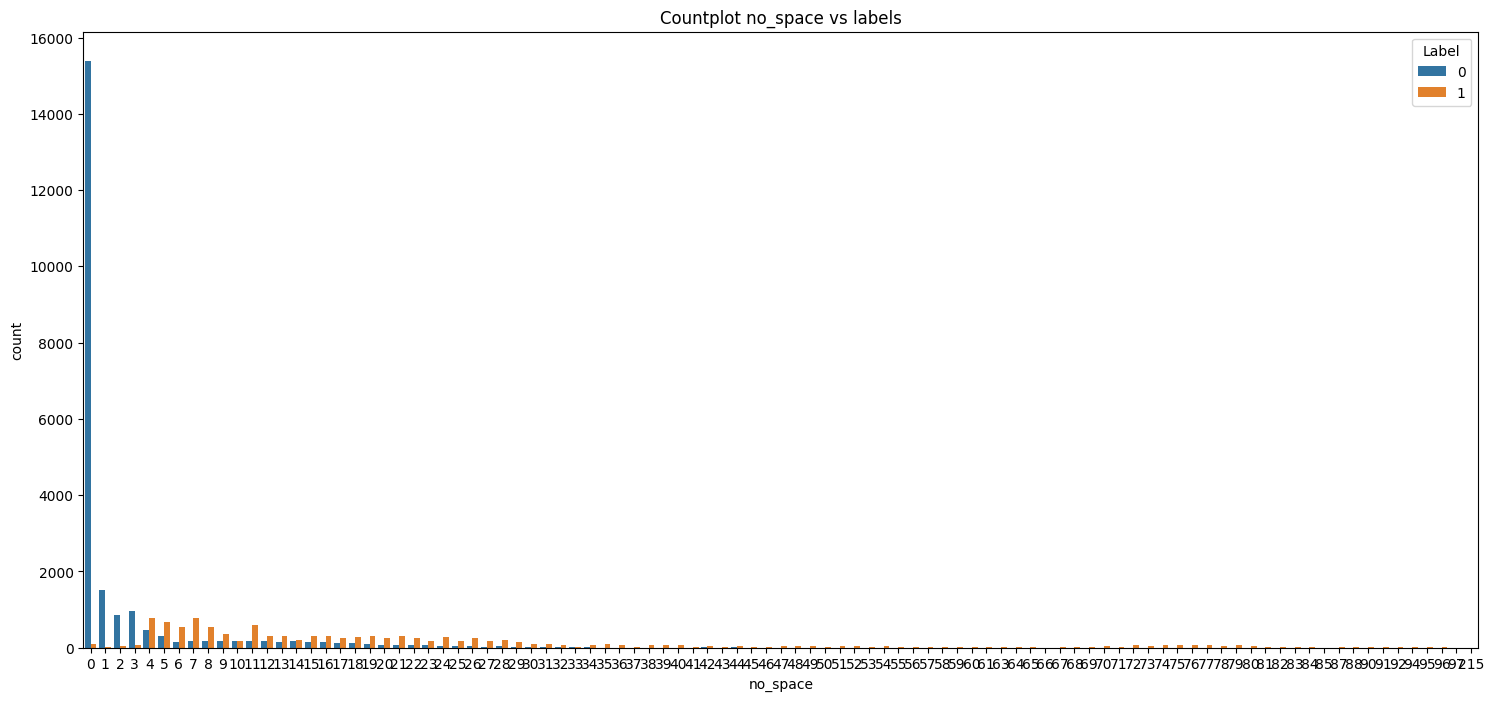

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_space'],hue = data['Label'],data=data)

plt.title("Countplot no_space vs labels")
plt.show()

Pengamatan :
- sulit untuk dianalisis karena jumlah spasi lebih banyak tetapi kita dapat melihat bahwa ada sedikit tumpang tindih hingga 33. setelah itu seiring dengan bertambahnya jumlah spasi, kemungkinan Kalimat menjadi kalimat injeksi sql juga meningkat.


###**4.3.3.14 Distribution of number of spaces**

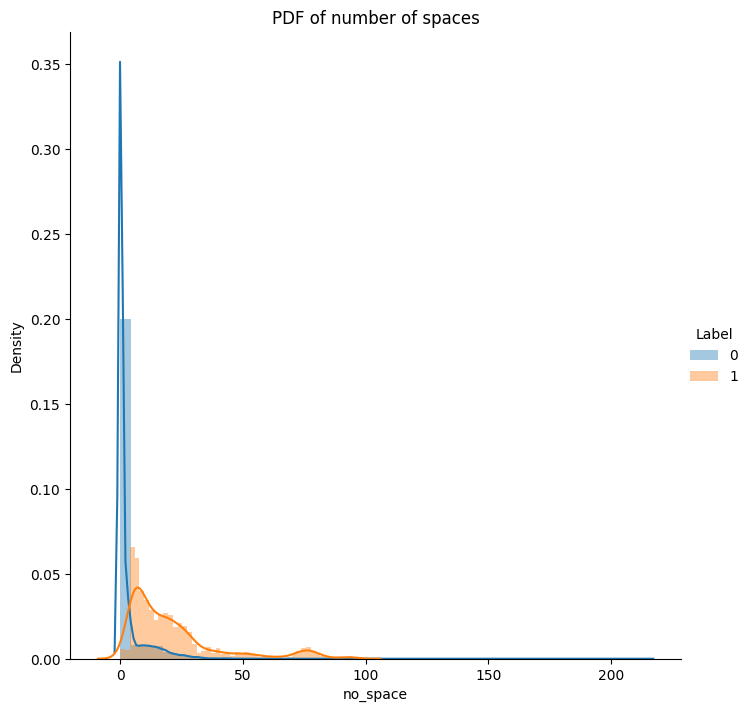

In [ ]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_space") \
   .add_legend()

plt.title("PDF of number of spaces")
plt.show()

- Kita bisa melihat ada sedikit tumpang tindih hingga tanggal 20 atau 21.
- seiring bertambahnya spasi setelah 20 kemungkinan Kalimat menjadi Kalimat injeksi sql juga tinggi.

##**4.4 Applying Logarithmic and Box cox transforms**

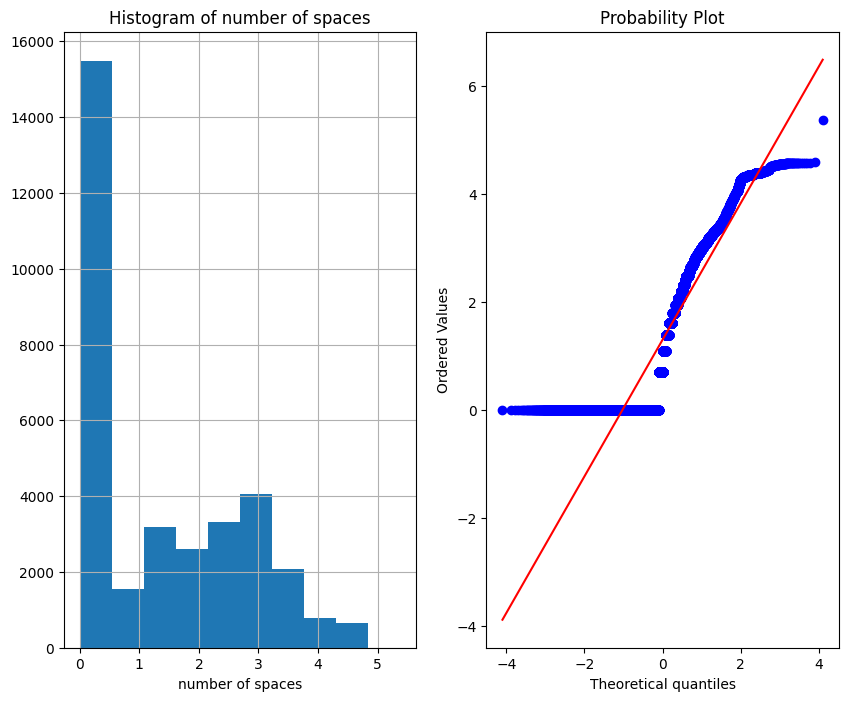

In [ ]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['no_space'] +1 ).hist()
plt.xlabel('number of spaces')
plt.title("Histogram of number of spaces")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['no_space']+1),dist = 'norm',plot = plt)
plt.show()

Distribusinya miring ke kanan, ini bukan distribusi Guassian yang sempurna

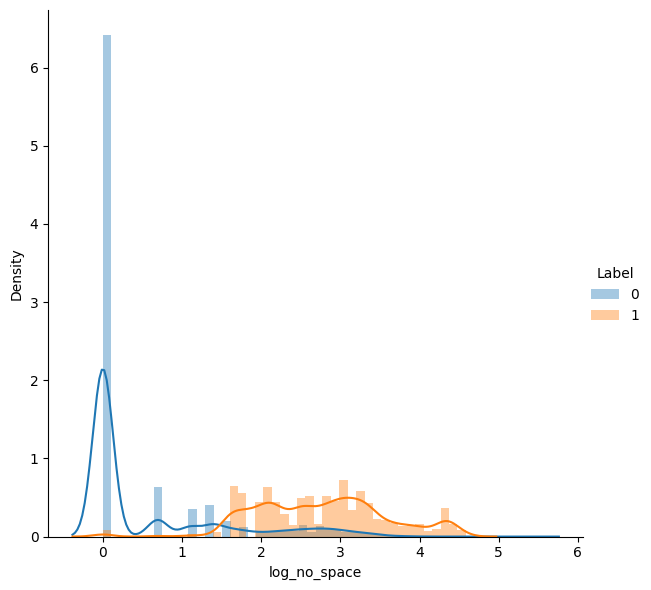

In [ ]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_no_space'] = data['no_space'].apply(lambda x : np.log(x+1))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_no_space") \
   .add_legend()

plt.show()

- Distribusi menunjukkan adanya tumpang tindih antara kelas label sehingga kami menghindari pengambilan nilai

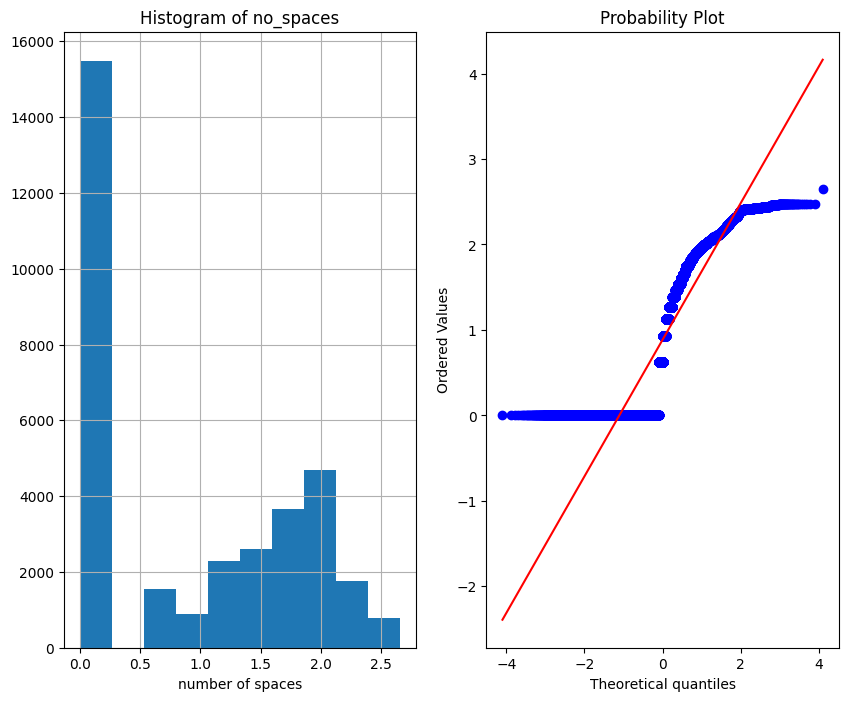

In [ ]:
#box-cox transformations
x,lamb = boxcox(data['no_space']+1,lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('number of spaces')
plt.title("Histogram of no_spaces")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()

Tidak ada perbedaan antara transformasi logaritmik dan transformasi box cox seperti yang dapat kita lihat dari plot di atas

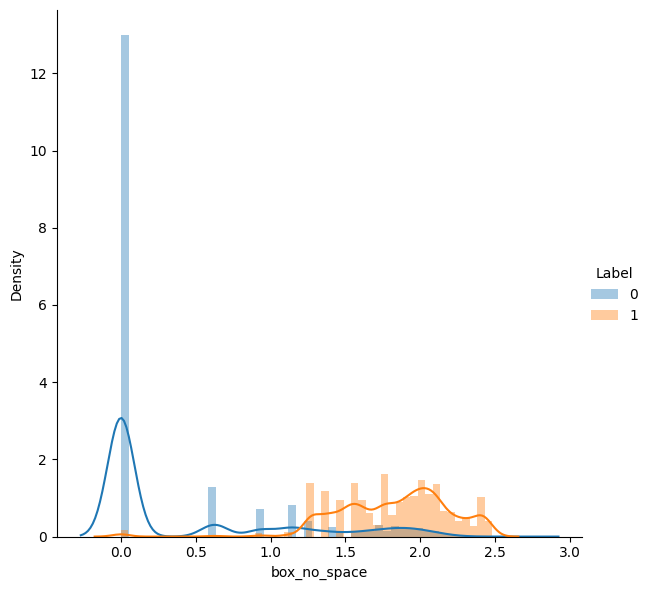

In [ ]:
#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_no_space'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_no_space") \
   .add_legend()

plt.show()

- Distribusi menunjukkan adanya tumpang tindih antar kelas sehingga kita menghindari pengambilan nilai

###**4.4.1 no_perc : Number of percentage(%) Symbols in a Sentence**

In [ ]:
#no_perc
#number of percentage symbols in a Sentence.
data['no_perc'].describe()

count    33723.000000
mean         0.071642
std          0.716396
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        117.000000
Name: no_perc, dtype: float64

###**4.4.1.1 Countplot : no_perc vs labels**

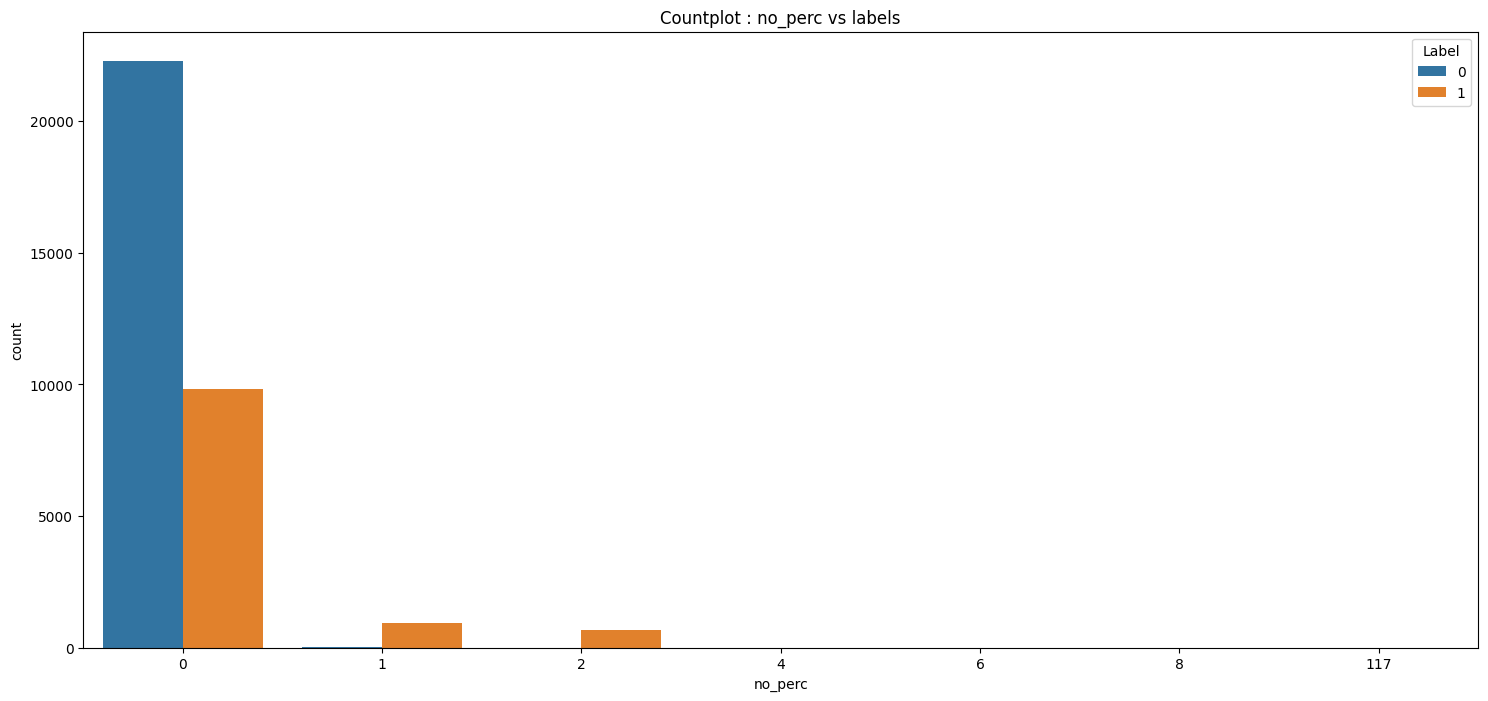

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_perc'],hue = data['Label'],data=data)

plt.title("Countplot : no_perc vs labels")
plt.show()

###**4.4.2 Distribution of no_perc**

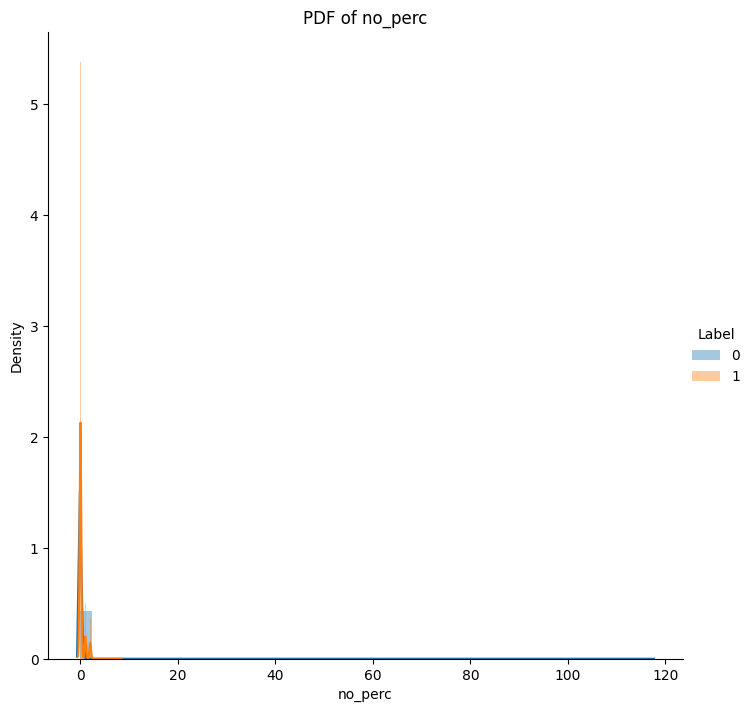

In [ ]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_perc",kde_kws = {'bw':0.3}) \
   .add_legend()
plt.title("PDF of no_perc")
plt.show()

Pengamatan:
- Banyak pertanyaan tidak mengandung simbol persentase.
- Hanya sejumlah kecil kueri yang mengandung simbol persentase.
- dari plot kita dapat melihat bahwa ada sedikit tumpang tindih hingga 2. tetapi seiring dengan meningkatnya simbol persentase, kemungkinan sebuah Kalimat menjadi kalimat injeksi sql juga meningkat.

###**4.4.3 no_log_opt : number of logical operators in a Sentence**

In [ ]:
#no_log_opt
#number of logical operators in a Sentence.
data['no_log_opt'].describe()

count    33723.000000
mean         0.560300
std          1.748241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: no_log_opt, dtype: float64

Logical operators lies in the range of 0 to 16.

###**4.4.3.1 Countplot : no_logical_opt vs labels**

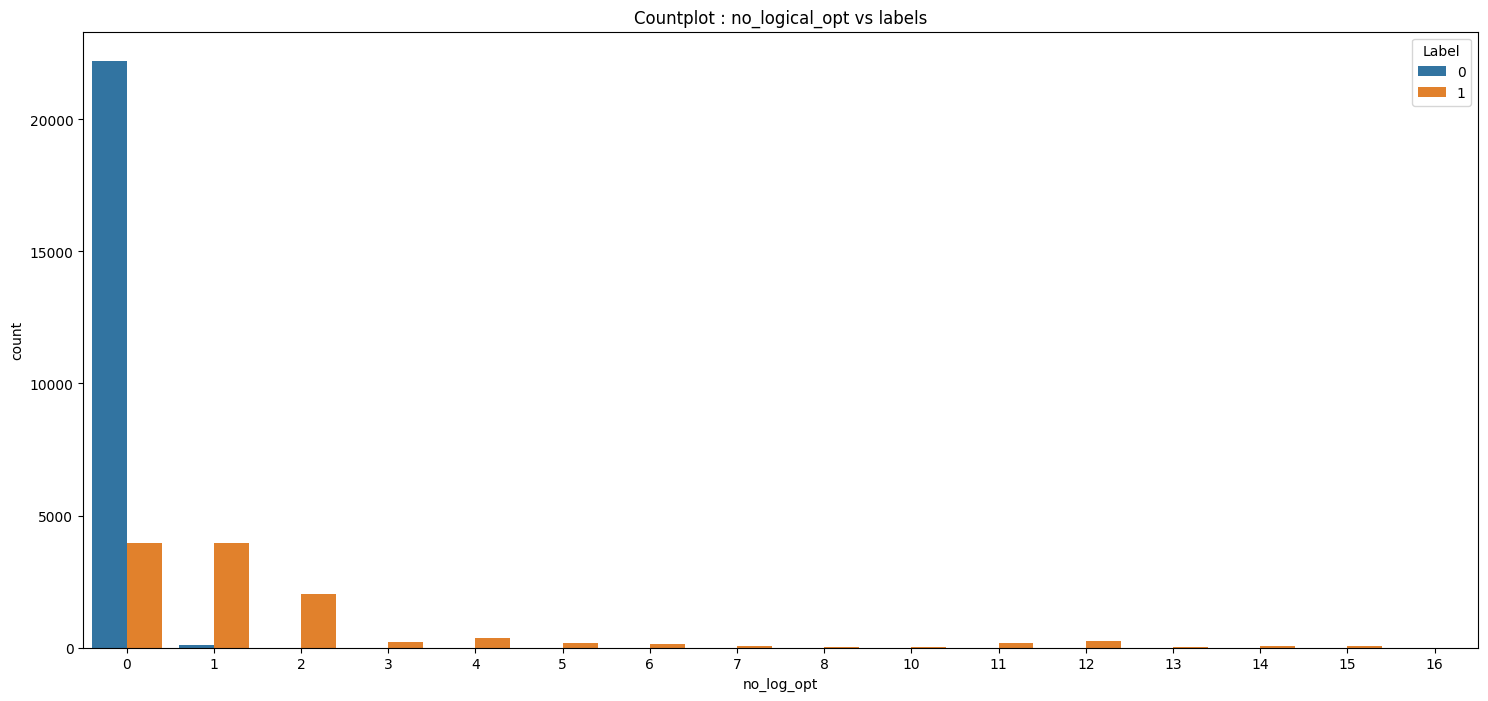

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_log_opt'],hue = data['Label'],data=data)

plt.title("Countplot : no_logical_opt vs labels")
plt.show()

Pengamatan :
- Seperti yang dapat kita lihat dengan jelas dari plot seiring bertambahnya jumlah operator logika setelah 4. maka itu adalah Kalimat injeksi sql.
- sebagian besar kueri tidak memiliki operasi logis, sebagian besar kueri berlabel 0.

###**4.4.4 no_arith : Number of arithmetic operators in a Sentence**

In [ ]:
#no_arith
#number of arithmetic operators in a Sentence.
data['no_arith'].describe()

count    33723.000000
mean         0.601459
std          3.137384
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        511.000000
Name: no_arith, dtype: float64

Logical operators lies in range of 0 to 511.

###**4.4.4.1 Countplot : no_arith vs labels**

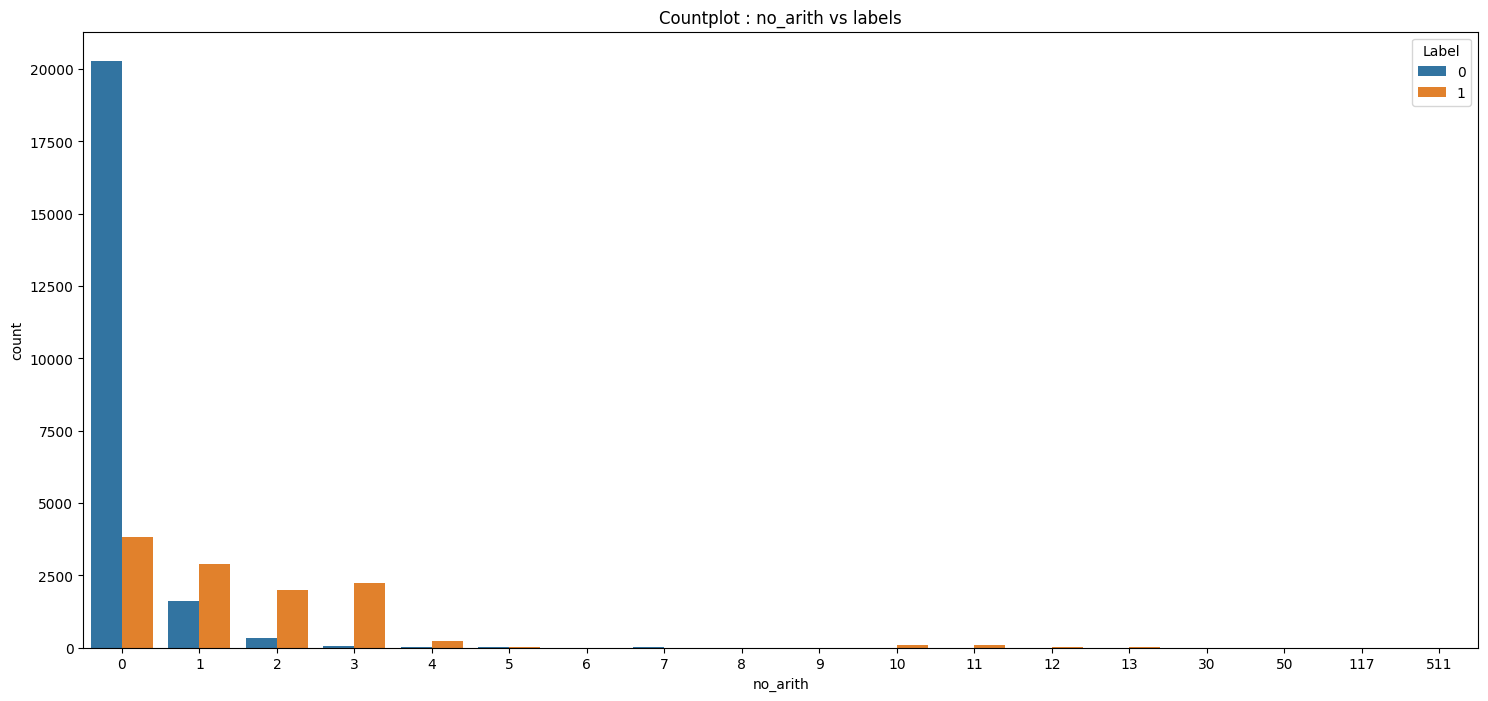

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_arith'],hue = data['Label'],data=data)

plt.title("Countplot : no_arith vs labels")
plt.show()

Pengamatan :
- Dari plot kita dapat mengamati jika jumlah operator aritmatika 4 atau lebih besar dari 7 maka querynya adalah query sql injection.
- Sebagian besar kueri tidak memiliki operator aritmatika dan sebagian besar kueri berlabel 0.

###**4.4.5 no_null : Number of null values in a Sentence**

In [ ]:
#no_null
#number of null values in a Sentence.
data['no_null'].describe()

count    33723.000000
mean         0.149186
std          0.932107
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: no_null, dtype: float64

Null values in a datset lies in a range of 0 to 10.

###**4.4.5.1 Countplot : no_null vs labels**

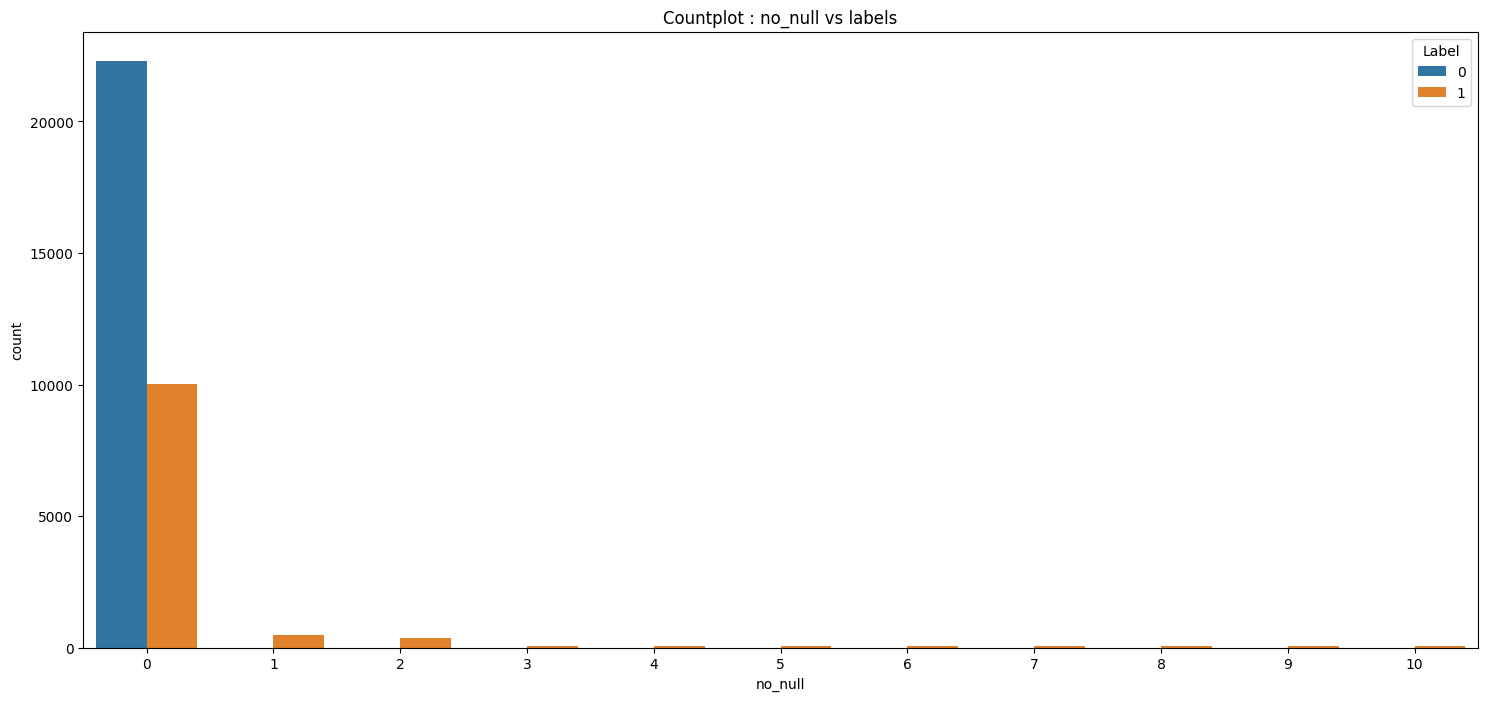

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_null'],hue = data['Label'],data=data)

plt.title("Countplot : no_null vs labels")
plt.show()

Pengamatan :
- jika jumlah nilai null lebih besar dari 2 maka itu adalah Kalimat injeksi sql.
- kami juga telah mengamati ini dari wordcloud bahwa nilai null lebih banyak muncul di kueri injeksi sql.

###**4.4.6 no_hexa : Number of hexa decimal values in a Sentence**

In [ ]:
#no_hexa
#number of hexadecimal values.
data['no_hexa'].describe()

count    33723.000000
mean         0.028497
std          0.175919
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: no_hexa, dtype: float64

Number of hexa decimal values lie in range of 0 to 11.

###**4.4.6.1 Countplot : no_hexa vs labels**

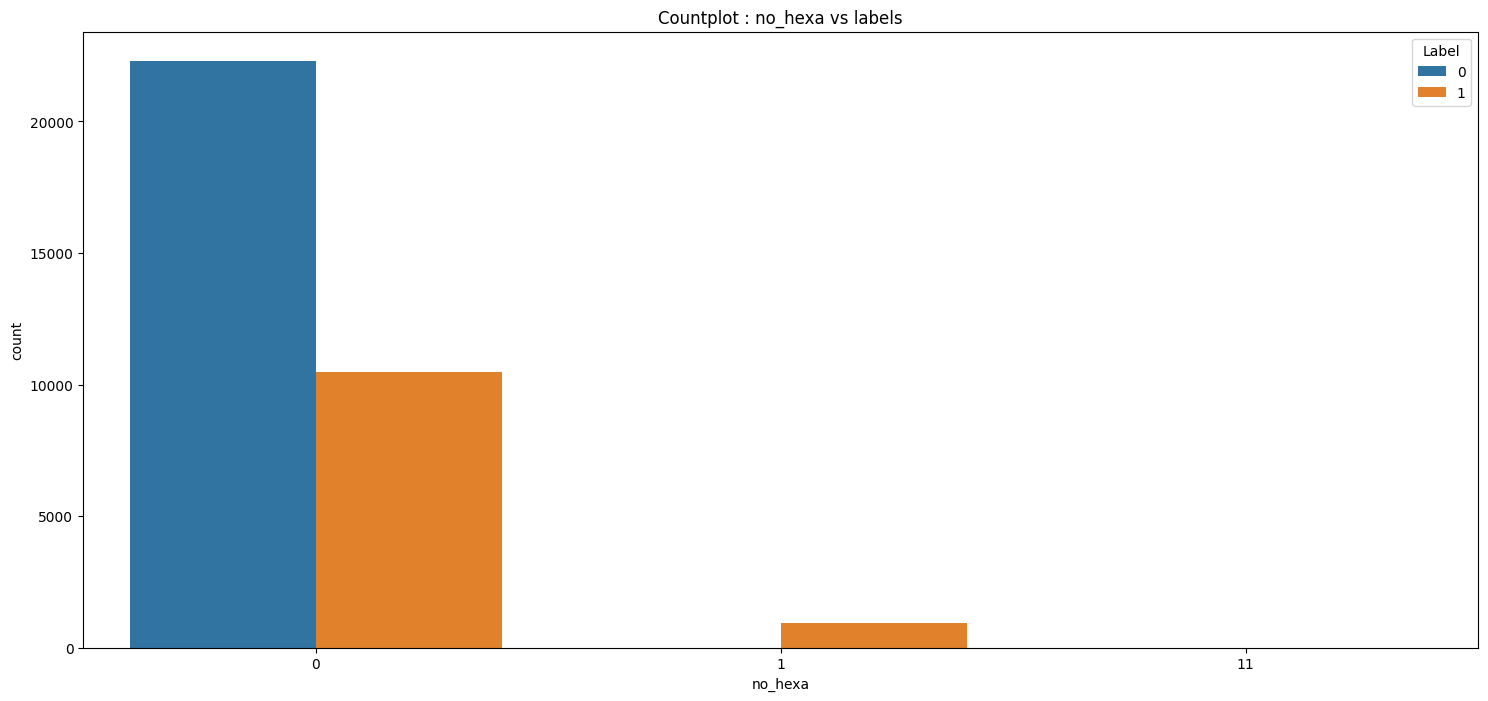

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_hexa'],hue = data['Label'],data=data)

plt.title("Countplot : no_hexa vs labels")
plt.show()

Pengamatan :
- Sebagian besar kueri tidak berisi nilai desimal heksa. kebanyakan dari mereka diberi label 0 kueri.
- jika jumlah nilai desimal heksa lebih besar atau sama dengan 1 maka itu adalah Kalimat injeksi sql.

###**4.4.7 no_alpha : Number of alphabets in a Sentence**

In [ ]:
#no_alpha
#number of alphabets in a Sentence.
data['no_alpha'].describe()

count    33723.000000
mean        24.786318
std         38.113217
min          0.000000
25%          5.000000
50%         12.000000
75%         31.000000
max       3784.000000
Name: no_alpha, dtype: float64

###**4.4.7.1 Countplot : no_alpha vs labels**

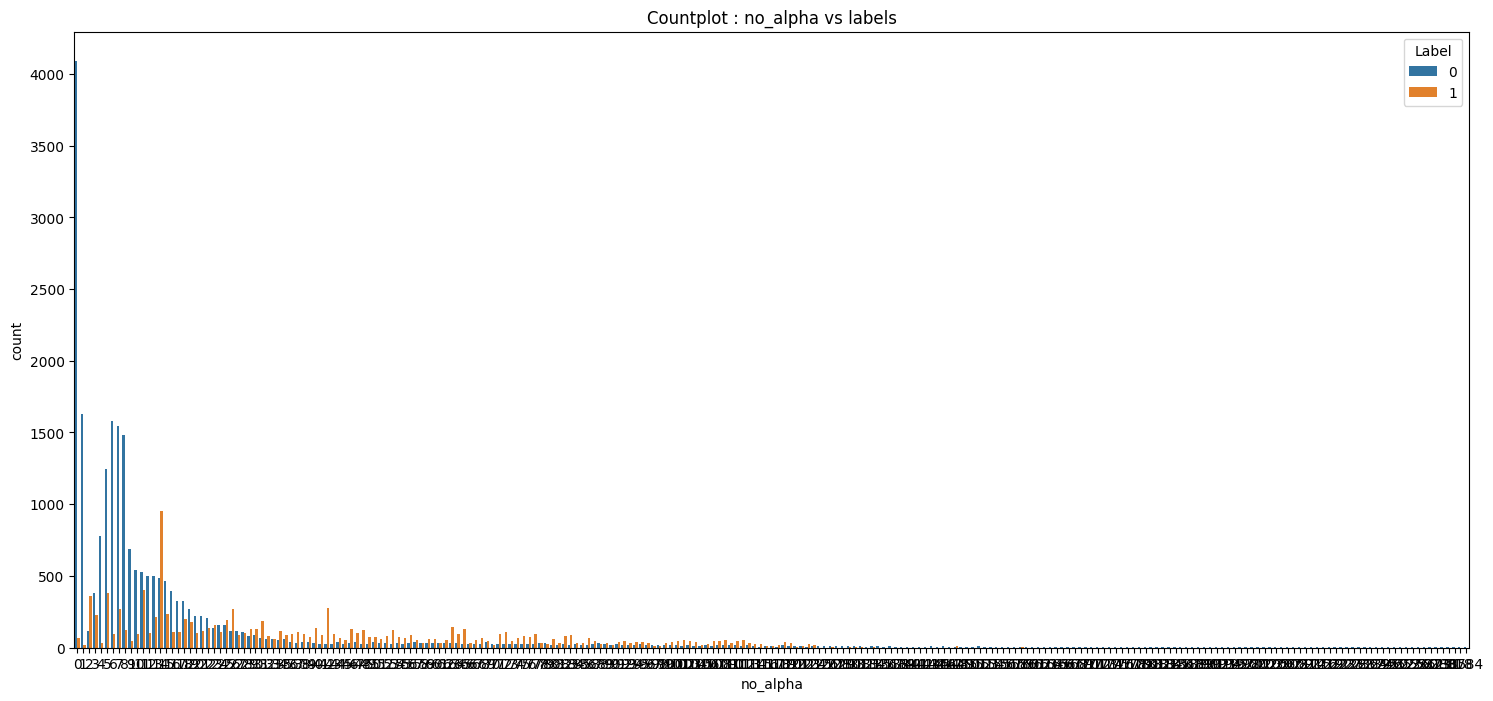

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_alpha'],hue = data['Label'],data=data)

plt.title("Countplot : no_alpha vs labels")
plt.show()

- sulit untuk menganalisis dari plot ini karena jumlah huruf yang lebih banyak akan memeriksa plot distribusi.

###**4.4.8 Distribution of no_alpha**

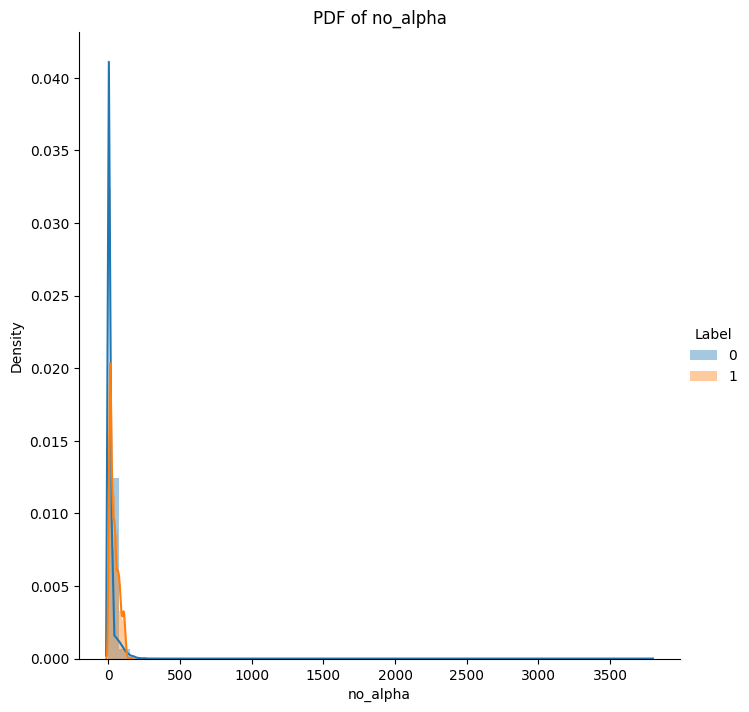

In [ ]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_alpha") \
   .add_legend()
plt.title("PDF of no_alpha")
plt.show()

Pengamatan :
- Ada tumpang tindih yang tinggi hingga 300.
- setelah 300 yaitu seiring dengan bertambahnya jumlah huruf, kemungkinan menjadi Kalimat sql juga meningkat.

###**4.4.9 no_digit : number of digits in a Sentence**

In [ ]:
#no_digit
#number of digits in a Sentence.
data['no_digit'].describe()

count    33723.000000
mean         8.135101
std         12.885568
min          0.000000
25%          0.000000
50%          3.000000
75%         10.000000
max        641.000000
Name: no_digit, dtype: float64

Number of digits lie in range of 0 to 641.

###**4.4.9.1 Countplot : no_digit vs labels**

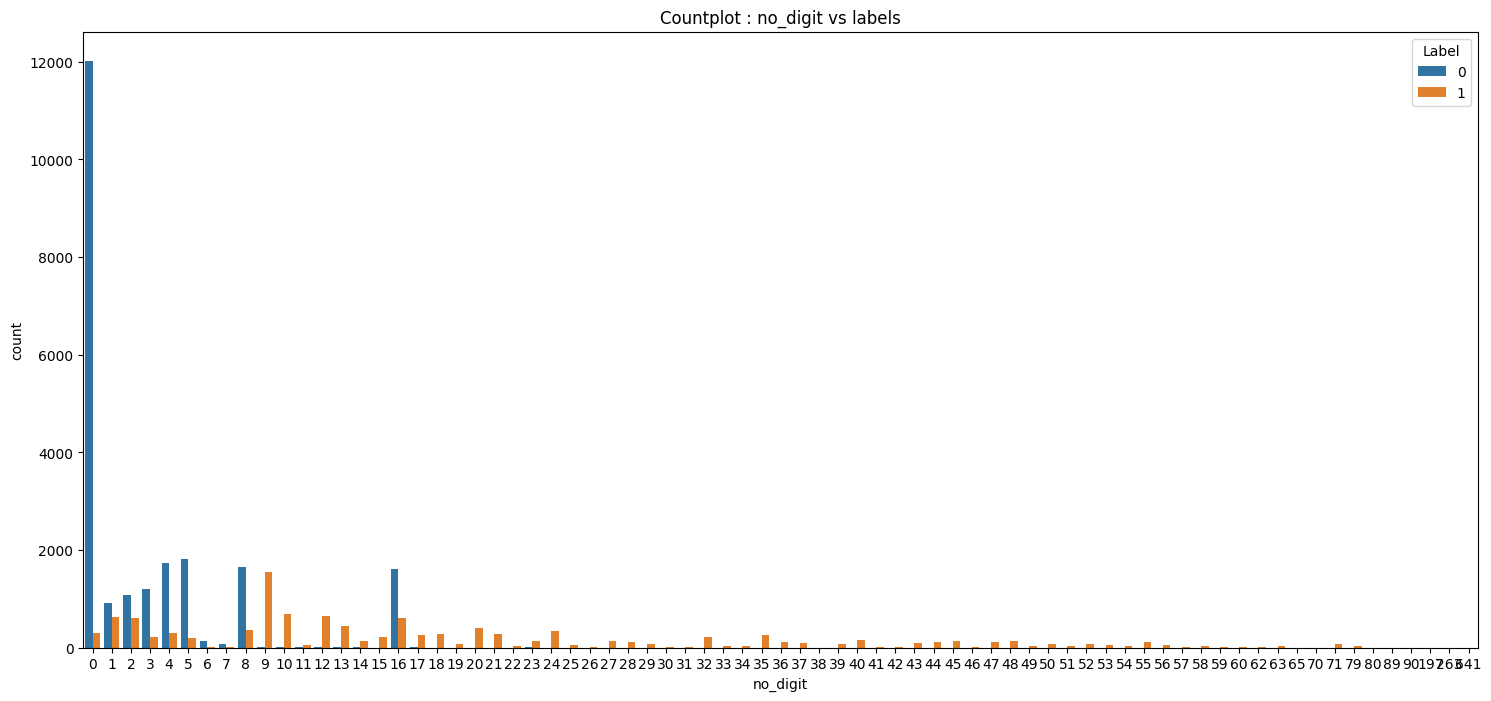

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_digit'],hue = data['Label'],data=data)

plt.title("Countplot : no_digit vs labels")
plt.show()

- Sepertinya ada sedikit tumpang tindih hingga 18. setelah itu, yaitu seiring bertambahnya jumlah digit, kemungkinannya menjadi Kalimat injeksi sql meningkat.
- akan lebih memahaminya dengan merencanakan distribusi.

###**4.4.10 Distribution of no_digit**

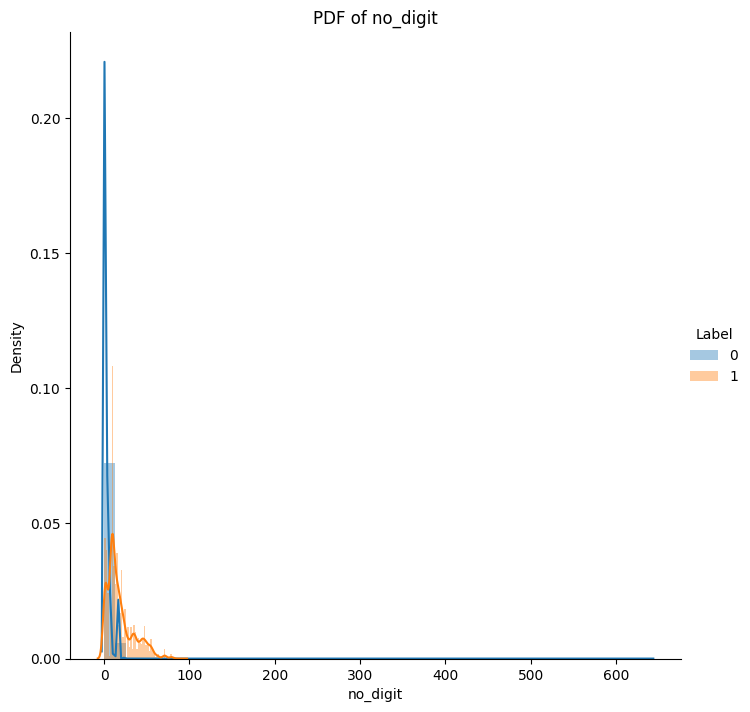

In [ ]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_digit") \
   .add_legend()
plt.title("PDF of no_digit")
plt.show()

Pengamatan :
- Seperti yang dapat kita amati dari plot, seiring bertambahnya jumlah digit, kemungkinan Kalimat yang diberikan menjadi Kalimat injeksi sql juga meningkat.

##**4.5 Length of chr,char,null keywords**

In [ ]:
data['len_of_chr_char_null'].describe()

count    33723.000000
mean         0.521009
std          2.071765
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: len_of_chr_char_null, dtype: float64

Pengamatan :
- Panjang kata kunci di atas terletak pada rentang 0 hingga 13 dalam kumpulan data.
- Seperti yang bisa kita lihat, 75 persen kueri tidak mengandung kata kunci ini. hanya lebih sedikit jumlah kueri yang mengandung kata kunci ini.

##**4.6 Countplot of Length of chr,char,null keywords**

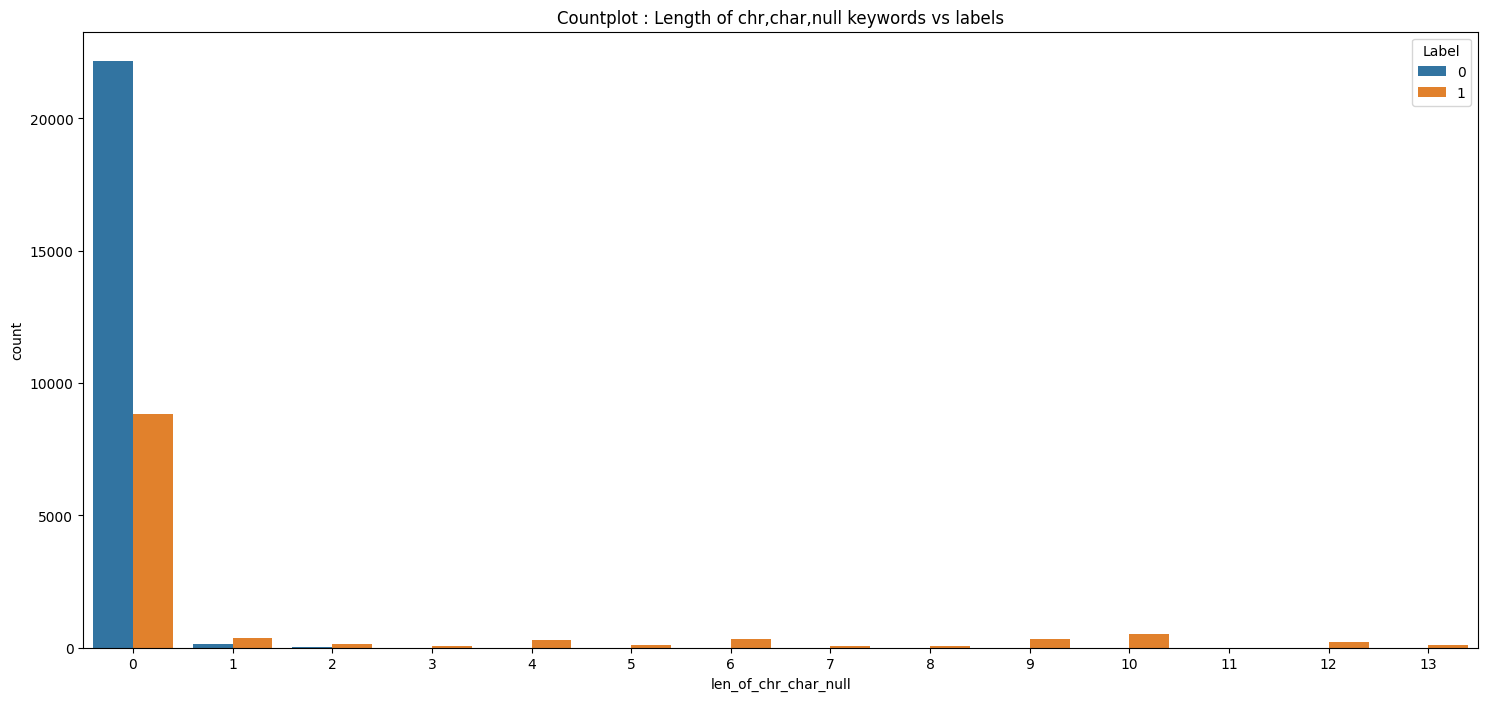

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['len_of_chr_char_null'],hue = data['Label'],data=data)

plt.title("Countplot : Length of chr,char,null keywords vs labels")
plt.show()

Pengamatan :
- Banyak kueri label 0 dan label 1 tidak berisi kueri di atas, mayoritas kueri sql normal.
- Seiring bertambahnya panjang kata kunci ini, yaitu setelah panjang 2, kemungkinan sebuah Kalimat menjadi Kalimat injeksi sql juga meningkat.
- kita dapat menulis model berbasis aturan sederhana seperti ini :
        if(len_of_chr_char_null >=2 )
             then label 1
        else:
               label 0

##**4.7 number of genuine keywords in each Sentence**

In [ ]:
data['genuine_keywords'].describe()

count    33723.000000
mean         0.032470
std          0.188282
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: genuine_keywords, dtype: float64

Observations :
- These keywords lie in the range of 0 to 3.
- 25 percent of queries does not contain these keywords

###**4.7.1 Countplot : count of genuine keywords vs labels**

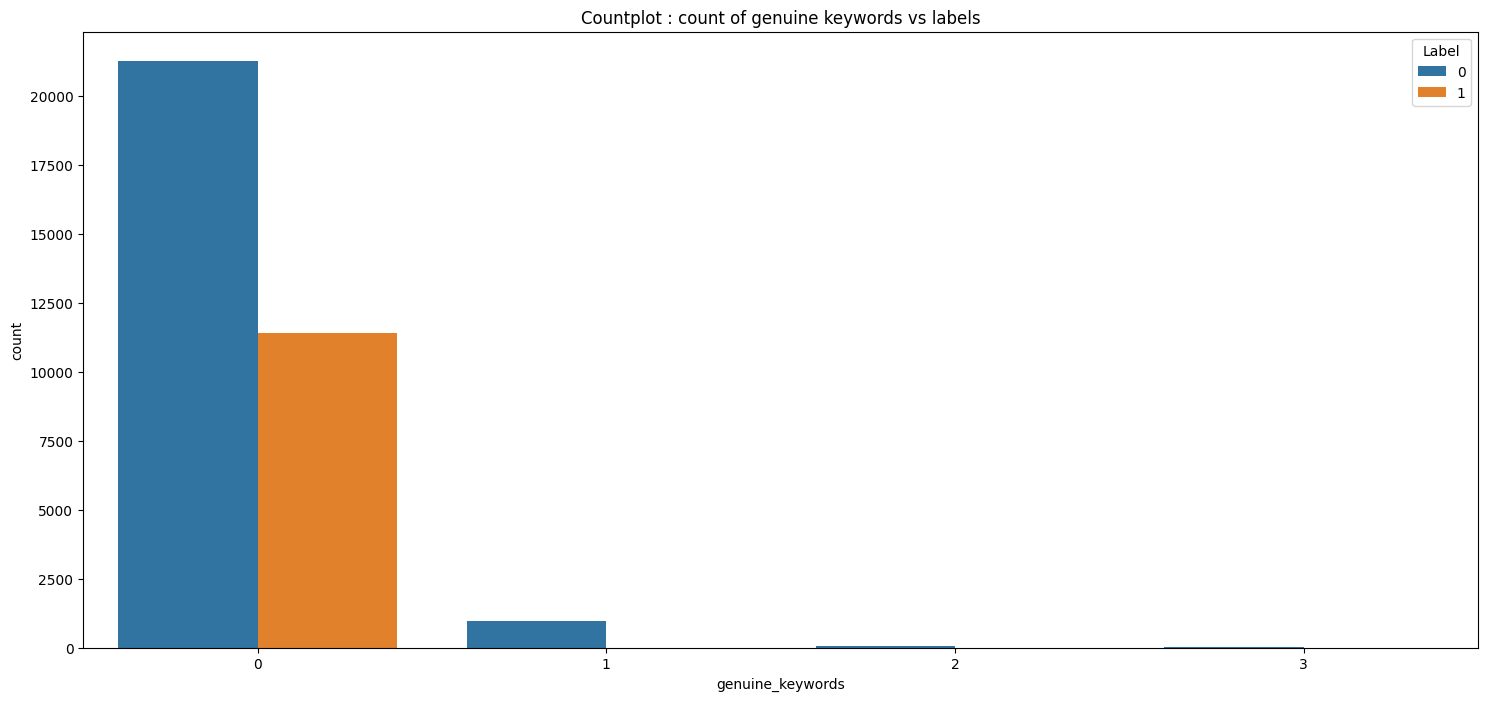

In [ ]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['genuine_keywords'],hue = data['Label'],data=data)

plt.title("Countplot : count of genuine keywords vs labels")
plt.show()

Pengamatan :
- Ada sedikit tumpang tindih antar kelas.
 - Seperti yang dapat kita amati jika jumlah kata kunci asli adalah 6 maka itu adalah Kalimat sql normal yaitu label 0 dan jika jumlah kata kunci asli adalah 7 maka itu adalah Kalimat sql berbahaya.
                      if(genuine_keywords == 6):
                            label 0
                      elif(genuine_keywords == 7):
                            label 1

##**4.8 Bivariate Analysis of extracted features**

- From the above univariate analysis below are the features that are helpful in predicting the given Sentence is sqli Sentence or not
       - no_single_qts
       - no_double_qts
       - no_punct
       - no_single_cmnt
       - no_mult_cmnt
       - no_space
       - no_perc
       - no_log_opt
       - no_arith
       - no_null
       - no_hexa
       - no_alpha
       - no_digit

###**4.8.1 Pairplots of no_single_qts, no_double_qts, no_punct, no_single_cmnt features**

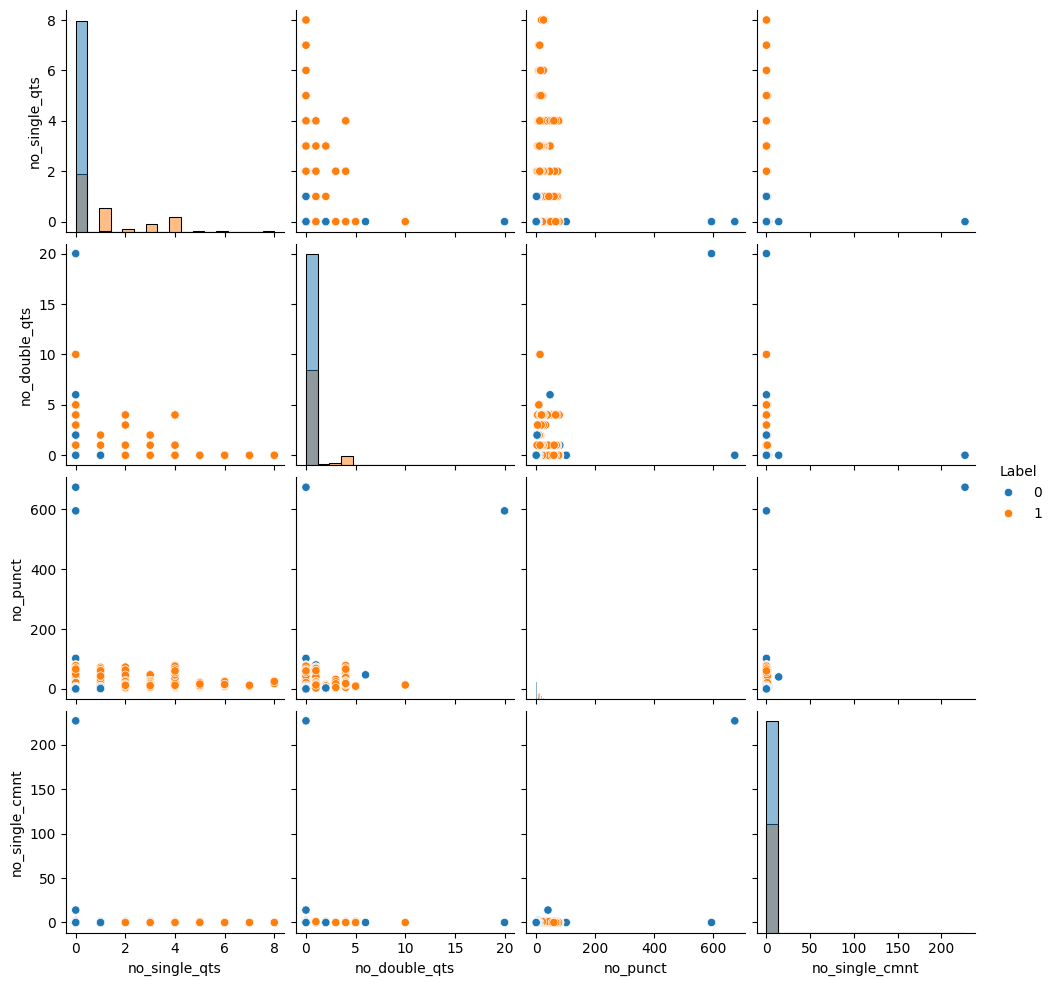

In [ ]:
#pair plot of the above features
#plotting all the features once will take lot of space and graphs does not look better for analysis
#so will take sample of features and plot
sns.pairplot(data = data,hue = 'Label',vars = ['no_single_qts',
       'no_double_qts', 'no_punct', 'no_single_cmnt'],diag_kind = "hist")
plt.show()

Pengamatan :
- no_single_qts vs no_single_cmnt, no_punct vs no_single_cmnt mudah dibedakan dan membantu dalam membedakan antara Kalimat sqli dan Kalimat sql.
- kita dapat menulis model berbasis aturan sederhana seperti:
          if(no_single_cmnt > 10 and no_punct > 200):
                then label 0
          else:
                label 1

###**4.8.2 Pairplots of no_mult_cmnt, no_space, no_perc, no_log_opt features**

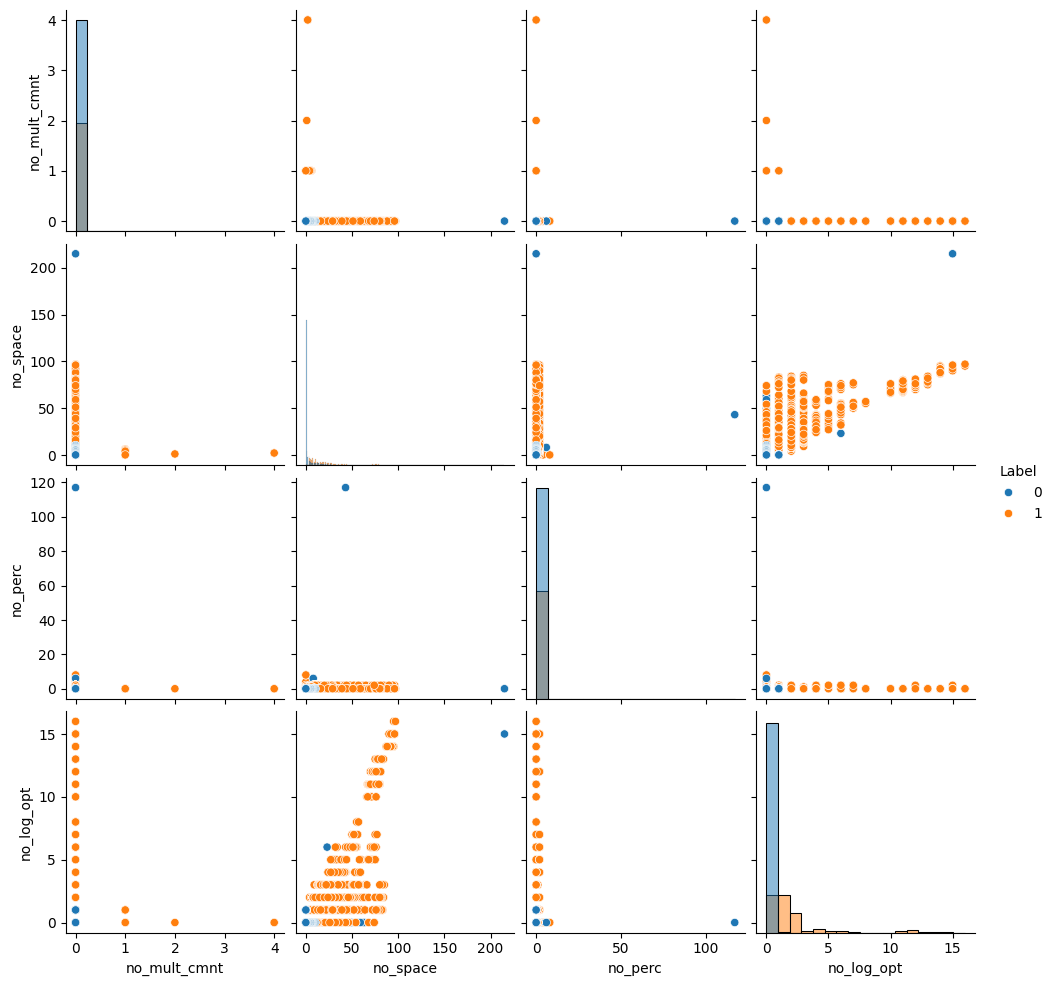

In [ ]:
#will take other features to plot
sns.pairplot(data = data,hue = 'Label',vars = ['no_mult_cmnt',
       'no_space', 'no_perc', 'no_log_opt'
     ],diag_kind = "hist")
plt.show()

Pengamatan :
- Hampir semua poin campur aduk, tidak ada fitur yang membantu dalam membedakan label

###**4.8.3 Pairplots of no_arith, no_null, no_hexa, no_alpha, no_digit features**

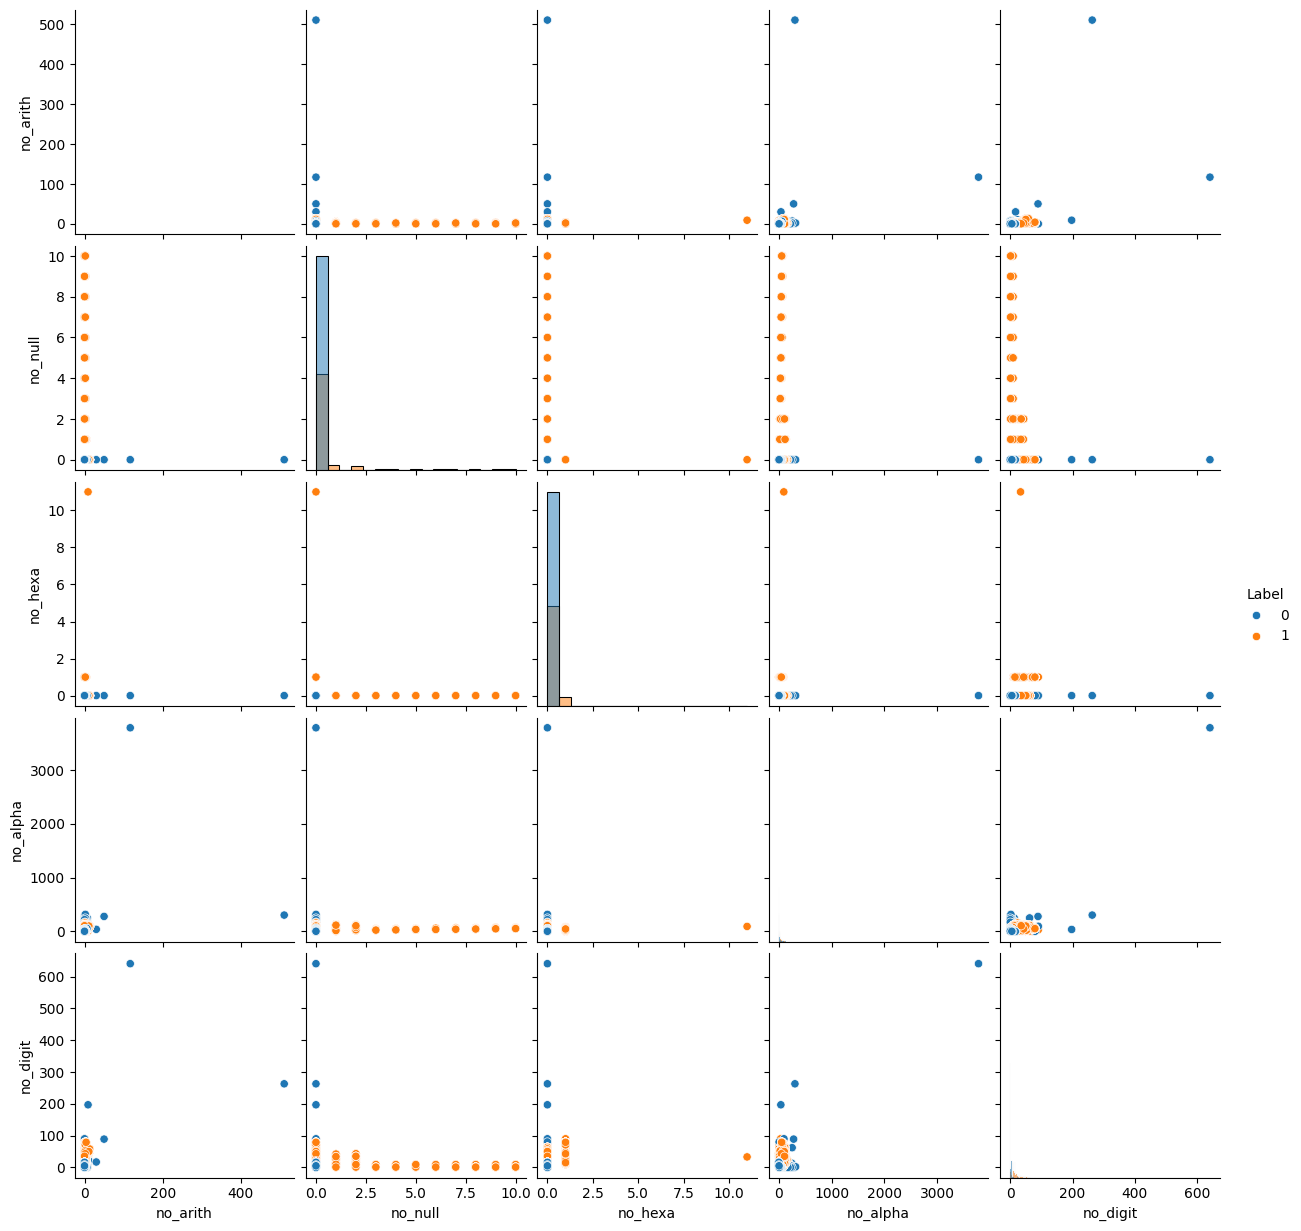

In [ ]:
sns.pairplot(data = data,hue = 'Label',vars = ['no_arith', 'no_null', 'no_hexa',
       'no_alpha', 'no_digit'],diag_kind = "hist")
plt.show()

Pengamatan :
- no null vs no_digit dan no_arith vs no_digit adalah grafik yang berguna dalam memprediksi label.
- Model aturan sederhana.

                     if(no_digit > 200)
                          then label 0
                     else:
                         label 1

##**4.9 Check Extracted features are helpful for classification or not**

In [ ]:
#use T-SNE for dimension reduction to extracted features to 2-dimension

tsne_data = TSNE(n_components = 2,n_jobs = -1).fit_transform(data[['Sentence_len', 'num_words_Sentence', 'no_single_qts',
       'no_double_qts', 'no_punct', 'no_single_cmnt', 'no_mult_cmnt',
       'no_space', 'no_perc', 'no_log_opt', 'no_arith', 'no_null', 'no_hexa',
       'no_alpha', 'no_digit','len_of_chr_char_null','genuine_keywords']])

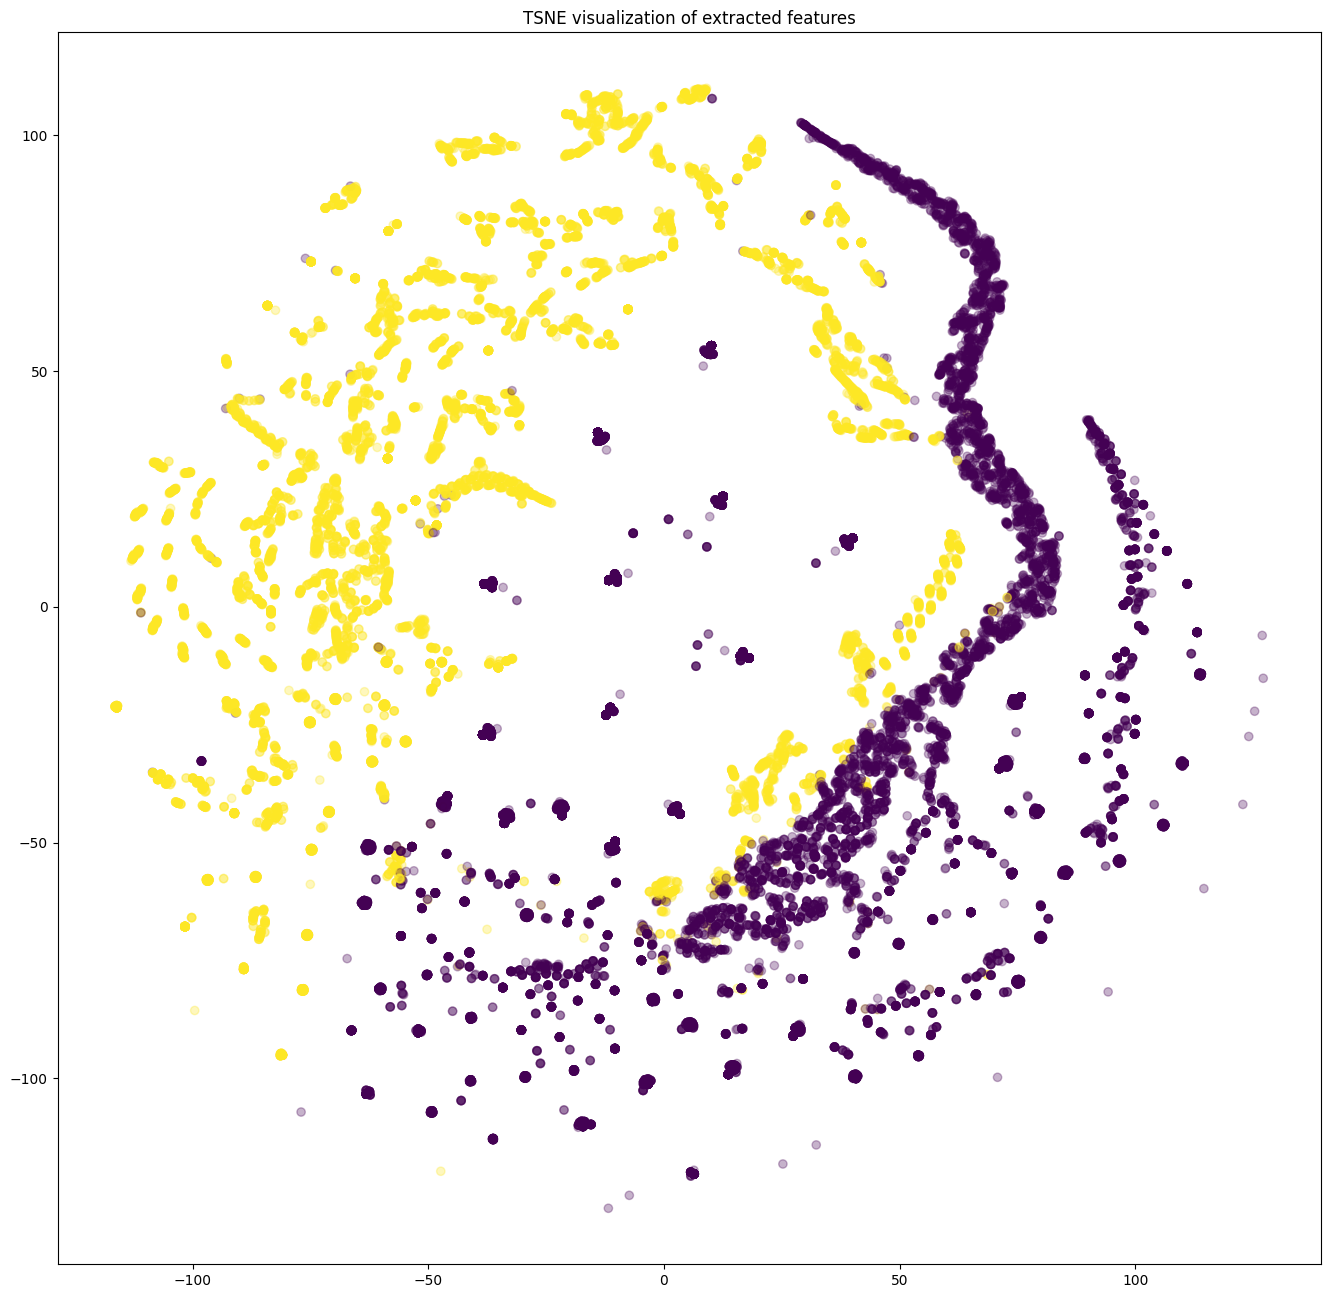

In [ ]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(tsne_data[:,1],
            tsne_data[:,0],
            c=data['Label'], alpha=0.3)
plt.title('TSNE visualization of extracted features')
plt.show()

Observations :
 - Some points are overlapping but almost points are well separated
 - Features are helpfull in model building.


Kesimpulan :
- Kumpulan data berisi baris duplikat dan kueri yang sama memiliki label berbeda yang dihapus.
- Dataset juga berisi query kosong yang ditemukan saat melakukan analisis fitur yang diekstraksi yaitu jumlah kata dalam Kalimat.
- Ada ketidakseimbangan kelas yaitu sebagian besar titik data termasuk dalam label 0 yang merupakan kueri sql normal atau teks biasa. Sebanyak 63 persen di antaranya berlabel 0 dan 37 persen di antaranya berlabel 1.
- sebagai bagian dari pemrosesan awal teks, konversi teks menjadi huruf kecil karena semua karakter atau teks penting dalam memprediksi label.
- Wordclouds diplot untuk mengamati kata-kata yang paling sering muncul dalam kueri sql dan sqli. ini nantinya akan digunakan untuk ekstraksi fitur.
- Menemukan null,char,chr dll adalah kata-kata yang paling banyak muncul di Kalimat sqli. sehingga kita dapat menampilkan nilai number_of null dalam sebuah Kalimat, dll.
- Kata kunci sql normal ditemukan dalam kueri sql.
- Analisis fitur yang diekstraksi telah selesai.
- Semua fitur berguna dalam memprediksi label. kecuali Panjang_Kalimat dan jumlah kata dalam sebuah Kalimat, kedua fitur ini tumpang tindih seperti yang telah kita lihat melalui plot distribusi.
- Terlepas dari kedua fitur ini, semuanya berguna dalam memprediksi label dengan ambang batas tertentu yang telah kita lihat menggunakan model berbasis aturan.
- Menggunakan plot hitungan, plot kotak, plot biola, dan plot distribusi untuk menganalisis fitur.
- Beberapa distribusi terlihat seperti terdistribusi lognormal atau terdistribusi hukum pangkat sehingga menerapkan transformasi logaritmik dan box-cox untuk memeriksa apakah mereka dapat ditransformasikan ke terdistribusi Guassian atau tidak. Ini bisa sangat membantu saat membangun model.
- Untuk memeriksa plot QQ yang terdistribusi atau tidak digunakan Guassian
- Analisis Bivariat dilakukan pada semua fitur, ditemukan beberapa fitur bermanfaat, ditulis beberapa model berbasis aturan berdasarkan beberapa kondisi fitur.
- akhirnya TSne digunakan untuk menganalisis fitur-fitur yang diekstraksi bermanfaat atau tidak alhasil beberapa titik tumpang tindih tetapi hampir semua titik terpisah dengan baik.
- Berdasarkan EDA yang dilakukan di atas. Metrik kinerja utama yang akan digunakan adalah:
         - Dari visualisasi TSNE di atas kita dapat melihat beberapa titik data yang salah klasifikasi.
         - Jadi kami ingin mengetahui seberapa banyak titik data yang salah klasifikasi.
         - sehingga kita dapat menggunakan matriks konfusi sebagai metrik kinerja.
         - Lebih lanjut tentang matriks kebingungan: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [ ]:
data.columns

Index(['Sentence', 'Label', 'Sentence_len', 'num_words_Sentence',
       'no_single_qts', 'no_double_qts', 'no_punct', 'no_single_cmnt',
       'no_mult_cmnt', 'no_space', 'no_perc', 'no_log_opt', 'no_arith',
       'no_null', 'no_hexa', 'no_alpha', 'no_digit', 'len_of_chr_char_null',
       'genuine_keywords', 'log_Sentence_len', 'box_Sentence_len',
       'log_num_words_Sentence', 'box_num_words_Sentence', 'log_no_space',
       'box_no_space'],
      dtype='object')

#**5. Featurizing text data or Given SQL Queries**

In [ ]:
data.head(10)

Sentence  Label  Sentence_len  \
1                       " or pg_sleep ( __time__ ) --      1            29   
2   create user name identified by pass123 tempora...      1            91   
3                                                 %29      1             3   
4   ' and 1 = utl_inaddr.get_host_address  (  (  s...      1           193   
5    select * from users where id = '1' or @ @1 = ...      1            82   
6    select * from users where id = 1 or 1#" (  un...      1            77   
7   ' select name from syscolumns where id  =   ( ...      1           102   
8    select * from users where id = 1 +$+ or 1 = 1...      1            51   
9   1; ( load_file ( char ( 47,101,116,99,47,112,9...      1            81   
10   select * from users where id = '1' or ||/1 = ...      1            82   

    num_words_Sentence  no_single_qts  no_double_qts  no_punct  \
1                    7              0              1        10   
2                   12              0              0         1   
3                    1              0              0         1   
4                   36              4              0        26   
5                   20              3              0        13   
6                   18              0              1        10   
7                   19              2              0         8   
8                   15              0              0         8   
9                   11              0              0        22   
10                  19              3              0        14   

    no_single_cmnt  no_mult_cmnt  no_space  ...  no_alpha  no_digit  \
1                1             0         6  ...        13         0   
2                0             0        12  ...        75         3   
3                0             0         0  ...         0         2   
4                0             0        35  ...       120         2   
5                1             0        20  ...        42         5   
6                1             0        18  ...        42         4   
7                1             0        18  ...        71         0   
8                1             0        15  ...        24         4   
9                0             0        10  ...        12        33   
10               1             0        19  ...        42         5   

    len_of_chr_char_null  genuine_keywords  log_Sentence_len  \
1                      0                 0          3.367296   
2                      0                 0          4.510860   
3                      0                 0          1.098612   
4                      0                 0          5.262690   
5                      0                 0          4.406719   
6                      0                 0          4.343805   
7                      0                 0          4.624973   
8                      0                 0          3.931826   
9                      1                 0          4.394449   
10                     0                 0          4.406719   

    box_Sentence_len  log_num_words_Sentence  box_num_words_Sentence  \
1           2.674687                1.945910                1.455781   
2           3.327873                2.484907                1.724802   
3           1.016958                0.000000                0.000000   
4           3.702839                3.583519                2.150347   
5           3.272695                2.995732                1.940970   
6           3.238962                2.890372                1.899179   
7           3.387403                2.944439                1.920797   
8           3.010434                2.708050                1.823510   
9           3.266140                2.397895                1.684397   
10          3.272695                2.944439                1.920797   

    log_no_space  box_no_space  
1       1.945910      1.470558  
2       2.564949      1.783789  
3       0.000000      0.000000  
4       3.583519      2.187047  
5       3.0445

In [ ]:
#dropping the Sentence_len,num_words_Sentence because from the EDA we got to know that it is not very much helpful in predicting the output classes
data.drop(['Sentence_len','num_words_Sentence'],axis= 1,inplace = True)

In [ ]:
y = data['Label']
x = data.drop('Label',axis = 1)

##**5.1 Splitting the dataset to train and test**

In [ ]:
#importing essential libararies
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
from scipy.sparse import hstack
from scipy import sparse
import pickle
from sklearn.preprocessing import StandardScaler

In [ ]:
# Split the data into training and testing sets (25% for testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, test_size = 0.25)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,stratify = y)

print("train dataset size is {}".format(x_train.shape))
print("test dataset size is {}".format(x_test.shape))

train dataset size is (25292, 22)
test dataset size is (8431, 22)


In [ ]:
#storing for future use
with open('x_train','wb') as f:
    pickle.dump(x_train,f)
with open('x_test','wb') as f:
    pickle.dump(x_test,f)
with open('y_train','wb') as f:
    pickle.dump(y_train,f)
with open('y_test','wb') as f:
    pickle.dump(y_test,f)

##**5.2 Featurizing text data or Given SQL Queries using Bag of words**

In [ ]:
#using countvectorizer for bag of words
#using bag of words for unigram range

unigram_bow = CountVectorizer(ngram_range = (1,1))
train_bow = unigram_bow.fit(x_train['Sentence'].values)


print("After Encoding text data")
x_train_bow_unigram = train_bow.transform(x_train['Sentence'].values)
x_test_bow_unigram = train_bow.transform(x_test['Sentence'].values)


print("the shape of train dataset unigram is {}".format(x_train_bow_unigram.shape))
print("the shape of test dataset unigram is  {}".format(x_test_bow_unigram.shape))

After Encoding text data
the shape of train dataset unigram is (25292, 32796)
the shape of test dataset unigram is  (8431, 32796)


In [ ]:
with open('unigram_bow','wb') as f:
    pickle.dump(unigram_bow,f)

In [ ]:
#saving train_bow for future use
with open('train_bow','wb') as f:
    pickle.dump(train_bow,f)

In [ ]:
#will use bigram range of values to build bow
bigram_bow = CountVectorizer(ngram_range = (2,2))
train_bigram_bow = bigram_bow.fit(x_train['Sentence'].values)

print("After Encoding text data")
x_train_bow_bigram = train_bigram_bow.transform(x_train['Sentence'].values)
x_test_bow_bigram = train_bigram_bow.transform(x_test['Sentence'].values)


print("the shape of train dataset unigram is {}".format(x_train_bow_bigram.shape))
print("the shape of test dataset unigram is  {}".format(x_test_bow_bigram.shape))


After Encoding text data
the shape of train dataset unigram is (25292, 53588)
the shape of test dataset unigram is  (8431, 53588)


##**5.3 Encoding Numerical features**

###**5.3.1 Encoding Numerical feature : number of single line quotation marks**

In [ ]:
'''
Since we have numerical features will transform the numerical features using standardscaler method

'''
#Generalized function for standardscaler method
def transform(x_train,x_test):
    sc = StandardScaler()
    sc.fit(x_train.reshape(-1,1))
    train_d = sc.transform(x_train.reshape(-1,1))
    test_d = sc.transform(x_test.reshape(-1,1))
    return train_d,test_d


train_no_single_qts,test_no_single_qts  = transform(np.array(x_train['no_single_qts']).
                                          reshape(-1,1),np.array(x_test['no_single_qts']).reshape(-1,1))
print("the shape of no_single_qts after Encoding is {}".format(train_no_single_qts.shape))

the shape of no_single_qts after Encoding is (25292, 1)


**5.3.2 Encoding Numerical feature : number of double line quotation marks**

In [ ]:
train_no_double_qts,test_no_double_qts  = transform(np.array(x_train['no_double_qts']).reshape(-1,1),np.array(x_test['no_double_qts']).reshape(-1,1))
print("the shape of no_double_qts after Encoding is {}".format(train_no_double_qts.shape))

the shape of no_double_qts after Encoding is (25292, 1)


**5.3.3 Encoding Numerical feature : number of punctuations**

In [ ]:
#alpha value is choosen as 1 because if there are no elements present then denominator will be zero
train_no_punct,test_no_punct  = transform(np.array(x_train['no_punct']).reshape(-1,1),np.array(x_test['no_punct']).reshape(-1,1))
print("the shape of no_punct after Encoding is {}".format(test_no_punct.shape))

the shape of no_punct after Encoding is (8431, 1)


**5.3.4 Encoding Numerical feature : number of single line comments**

In [ ]:
train_no_single_cmnt,test_no_single_cmnt  = transform(np.array(x_train['no_single_cmnt']).reshape(-1,1),np.array(x_test['no_single_cmnt']).reshape(-1,1))
print("the shape of no_single_cmnt after Encoding is {}".format(train_no_single_cmnt.shape))

the shape of no_single_cmnt after Encoding is (25292, 1)


**5.3.5 Encoding Numerical feature : number of multi line comment**

In [ ]:
train_no_mult_cmnt,test_no_mult_cmnt = transform(np.array(x_train['no_mult_cmnt']).reshape(-1,1),np.array(x_test['no_mult_cmnt']).reshape(-1,1))
print("the shape of no_mult_cmnt after Encoding is {}".format(train_no_mult_cmnt.shape))

the shape of no_mult_cmnt after Encoding is (25292, 1)


**5.3.6 Encoding Numerical feature : number of space**

In [ ]:
train_no_space,test_no_space  = transform(np.array(x_train['no_space']).reshape(-1,1),np.array(x_test['no_space']).reshape(-1,1))
print("the shape of no_space after Encoding is {}".format(train_no_space.shape))

the shape of no_space after Encoding is (25292, 1)


**5.3.7 Encoding Numerical feature : number of percentage symbols**

In [ ]:
train_no_perc,test_no_perc  = transform(np.array(x_train['no_perc']).reshape(-1,1),np.array(x_test['no_perc']).reshape(-1,1))
print("the shape of no_perc after Encoding is {}".format(train_no_perc.shape))

the shape of no_perc after Encoding is (25292, 1)


**5.3.8 Encoding Numerical feature : number of logical operators**

In [ ]:
train_no_log_opt,test_no_log_opt  = transform(np.array(x_train['no_log_opt']).reshape(-1,1),np.array(x_test['no_log_opt']).reshape(-1,1))
print("the shape of no_log_opt after Encoding is {}".format(train_no_log_opt.shape))

the shape of no_log_opt after Encoding is (25292, 1)


**5.3.9 Encoding Numerical feature : number of arithmetic operators**

In [ ]:
train_no_arith_opt,test_no_arith_opt  = transform(np.array(x_train['no_arith']).reshape(-1,1),np.array(x_test['no_arith']).reshape(-1,1))
print("the shape of no_arith_opt after Encoding is {}".format(train_no_arith_opt.shape))

the shape of no_arith_opt after Encoding is (25292, 1)


**5.3.10 Encoding Numerical feature : number of null values**

In [ ]:
train_no_null,test_no_null  = transform(np.array(x_train['no_null']).reshape(-1,1),np.array(x_test['no_null']).reshape(-1,1))
print("the shape of no_null after Encoding is {}".format(train_no_null.shape))

the shape of no_null after Encoding is (25292, 1)


**5.3.11 Encoding Numerical feature : number of hexadecimal values**

In [ ]:
train_no_hexa,test_no_hexa = transform(np.array(x_train['no_hexa']).reshape(-1,1),np.array(x_test['no_hexa']).reshape(-1,1))
print("the shape of no_hexa after Encoding is {}".format(train_no_hexa.shape))

the shape of no_hexa after Encoding is (25292, 1)


**5.3.12 Encoding Numerical feature : number of alphabets**

In [ ]:
train_no_alpha,test_no_alpha = transform(np.array(x_train['no_alpha']).reshape(-1,1),np.array(x_test['no_alpha']).reshape(-1,1))
print("the shape of no_alpha after Encoding is {}".format(train_no_alpha.shape))

the shape of no_alpha after Encoding is (25292, 1)


**5.3.13 Encoding Numerical feature : number of digits**

In [ ]:
train_no_digit,test_no_digit = transform(np.array(x_train['no_digit']).reshape(-1,1),np.array(x_test['no_digit']).reshape(-1,1))
print("the shape of no_digit after Encoding is {}".format(train_no_digit.shape))

the shape of no_digit after Encoding is (25292, 1)


**5.3.14 Encoding Numerical feature : length of che,char and null keywords combined**

In [ ]:
train_len_of_chr_char_null,test_len_of_chr_char_null  = transform(np.array(x_train['len_of_chr_char_null']).reshape(-1,1),np.array(x_test['len_of_chr_char_null']).reshape(-1,1))
print("the shape of len_of_chr_char_null after Encoding is {}".format(train_len_of_chr_char_null.shape))

the shape of len_of_chr_char_null after Encoding is (25292, 1)


**5.3.15 Encoding Numerical feature : length of genuine_keywords**

In [ ]:
train_genuine_keywords,test_genuine_keywords  = transform(np.array(x_train['genuine_keywords']).reshape(-1,1),np.array(x_test['genuine_keywords']).reshape(-1,1))
print("the shape of genuine_keywords after Encoding is {}".format(train_genuine_keywords.shape))

the shape of genuine_keywords after Encoding is (25292, 1)


##**5.4 Combining all the features encoded above**

**5.4.1 Concatenating Encoded features with bag of words unigram range encoding**

In [ ]:
train_data_bow_unigram = hstack((x_train_bow_unigram,train_no_single_qts,train_no_double_qts,train_no_punct,train_no_single_cmnt,train_no_mult_cmnt,train_no_space,train_no_perc,train_no_log_opt,train_no_arith_opt,train_no_null,train_no_hexa,train_no_alpha,train_no_digit,train_len_of_chr_char_null,train_genuine_keywords)).tocsr()
test_data_bow_unigram = hstack((x_test_bow_unigram,test_no_single_qts,test_no_double_qts,test_no_punct,test_no_single_cmnt,test_no_mult_cmnt,test_no_space,test_no_perc,test_no_log_opt,test_no_arith_opt,test_no_null,test_no_hexa,test_no_alpha,test_no_digit,test_len_of_chr_char_null,test_genuine_keywords)).tocsr()

**5.4.2 Concatenating Encoded features with bag of words bigram range encoding**

In [ ]:
train_data_bow_bigram = hstack((x_train_bow_bigram,train_no_single_qts,train_no_double_qts,train_no_punct,train_no_single_cmnt,train_no_mult_cmnt,train_no_space,train_no_perc,train_no_log_opt,train_no_arith_opt,train_no_null,train_no_hexa,train_no_alpha,train_no_digit,train_len_of_chr_char_null,train_genuine_keywords)).tocsr()
test_data_bow_bigram = hstack((x_test_bow_bigram,test_no_single_qts,test_no_double_qts,test_no_punct,test_no_single_cmnt,test_no_mult_cmnt,test_no_space,test_no_perc,test_no_log_opt,test_no_arith_opt,test_no_null,test_no_hexa,test_no_alpha,test_no_digit,test_len_of_chr_char_null,test_genuine_keywords)).tocsr()

In [ ]:
#storing all features generated above for further use
sparse.save_npz("train_data_bow_unigram.npz",train_data_bow_unigram)
sparse.save_npz("test_data_bow_unigram.npz",test_data_bow_unigram)

In [ ]:
sparse.save_npz("test_data_bow_bigram.npz",test_data_bow_bigram)
sparse.save_npz("train_data_bow_bigram.npz",train_data_bow_bigram)

In [ ]:
x_train.to_csv('x_train.csv')
x_test.to_csv('x_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [ ]:
#importing neccessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,log_loss
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
import joblib
from prettytable import PrettyTable
from xgboost import plot_importance

#**6. Machine Learning Models**


In [ ]:
#writing generalised function to plot the confusion matrix,precision and recall matrix
#this code is taken from case studies of APPlied AI course
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1]
    plt.figure(figsize = (20,5))
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

##**6.1 Building Random model to find worst case F1-Score**

In [ ]:
#first will load the npz file of unigram words train and test data
bow_unigram_train = sparse.load_npz('train_data_bow_unigram.npz')
bow_unigram_test = sparse.load_npz('test_data_bow_unigram.npz')
with open('y_train','rb') as f:
    y_train = pickle.load(f)

with open('y_test','rb') as f:
    y_test = pickle.load(f)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

f1-score on test data using Random model 0.4027072758037225


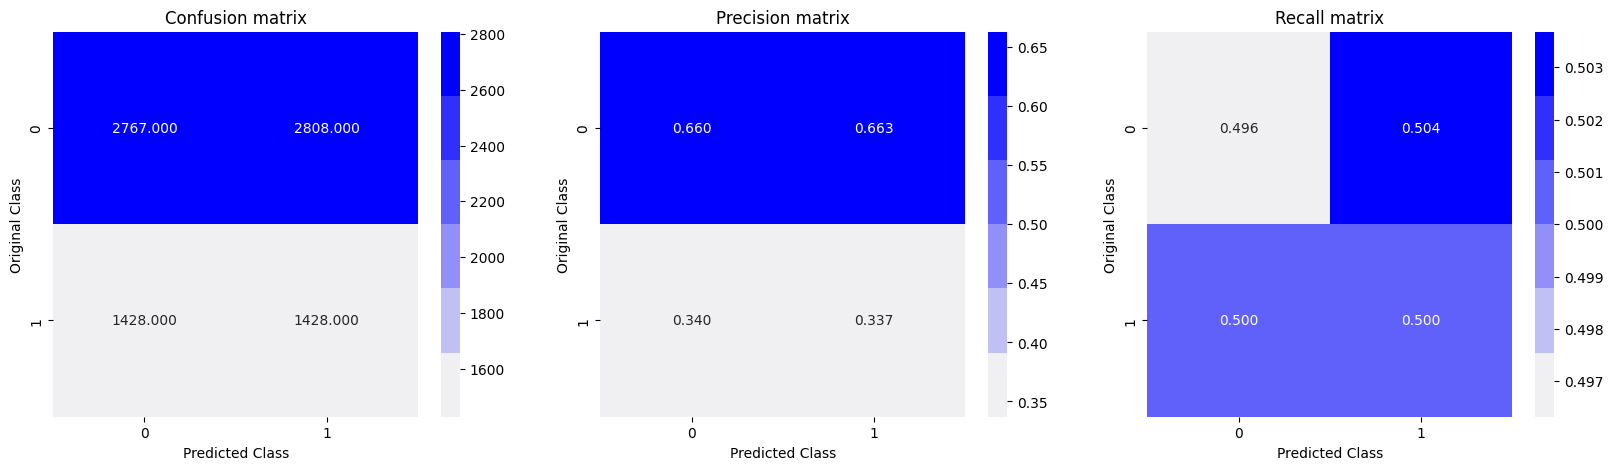

In [ ]:
#https://stackoverflow.com/a/18662466/4084039
pred_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    prob = np.random.rand(1,2)
    pred_y[i] = ((prob/sum(sum(prob)))[0])


pred_y =np.argmax(pred_y, axis=1)
print("f1-score on test data using Random model {}".format(f1_score(y_test,pred_y)))
plot_confusion_matrix(y_test, pred_y)

As we can see from the above result the worst case f1 score is 0.40.
So the f1 score should be more than the above f1 score

##**6.2 Accuracy Testing between Decision Tree and Random Forest (optional)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import sparse
import pickle

# Memuat data train dan test dari file npz
bow_unigram_train = sparse.load_npz('train_data_bow_unigram.npz')
bow_unigram_test = sparse.load_npz('test_data_bow_unigram.npz')

# Memuat label dari file pickle
with open('y_train','rb') as f:
    y_train = pickle.load(f)

with open('y_test','rb') as f:
    y_test = pickle.load(f)

# Membuat model Decision Tree
dt_model = DecisionTreeClassifier()
# Melatih model Decision Tree
dt_model.fit(bow_unigram_train, y_train)
# Melakukan prediksi dengan Decision Tree
dt_predictions = dt_model.predict(bow_unigram_test)
# Menghitung akurasi Decision Tree
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Akurasi Decision Tree:", dt_accuracy)

# Membuat model Random Forest
rf_model = RandomForestClassifier()
# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)
# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)
# Menghitung akurasi Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Akurasi Random Forest:", rf_accuracy)


Akurasi Decision Tree: 0.997271972482505
Akurasi Random Forest: 0.99857668129522


##**6.3 Visualize using Confussion Matrix**

##Random Forest (n_estimators=10, max_depth=10, min_samples_split=2, random_state=42)

Random Forest:
Accuracy: 0.9584865377772506
Precision: 0.9984089101034208
Recall: 0.8788515406162465
F1 Score: 0.9348230912476723


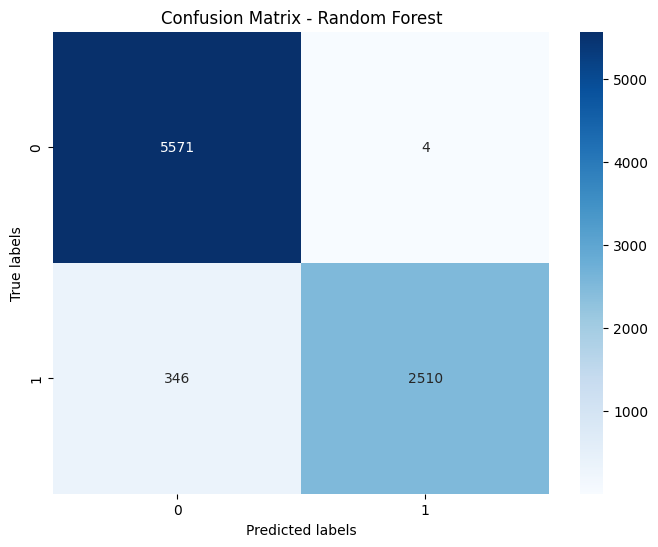

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_split=2, random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)

# Menghitung metrik evaluasi
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Menampilkan metrik evaluasi
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

##Random Forest (n_estimators=10, max_depth=20, min_samples_split=2, random_state=42)

Random Forest:
Accuracy: 0.9634681532439805
Precision: 1.0
Recall: 0.8921568627450981
F1 Score: 0.9430051813471504


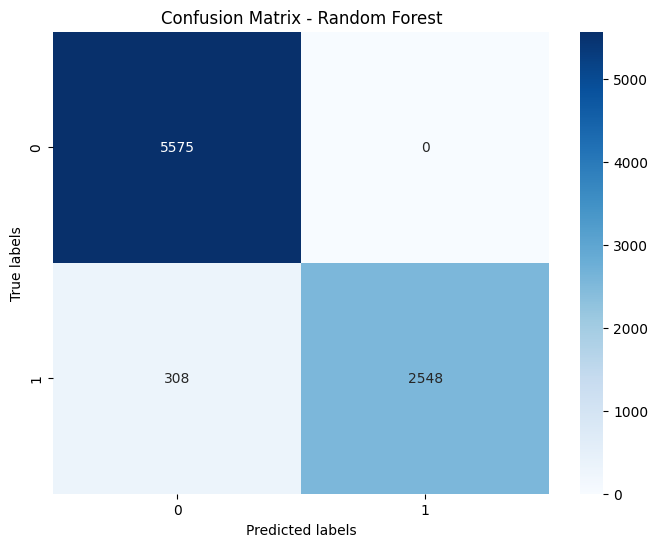

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=10, max_depth=20, min_samples_split=2, random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)

# Menghitung metrik evaluasi
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Menampilkan metrik evaluasi
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

##Random Forest (n_estimators=20, max_depth=20, min_samples_split=2, random_state=42)

Random Forest:
Accuracy: 0.9654845214090855
Precision: 1.0
Recall: 0.898109243697479
F1 Score: 0.9463198671831766


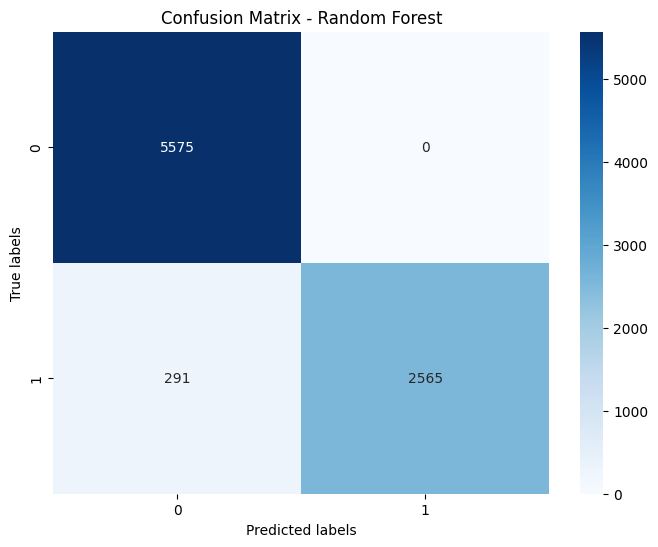

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=20, max_depth=20, min_samples_split=2, random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)

# Menghitung metrik evaluasi
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Menampilkan metrik evaluasi
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

##Random Forest (n_estimators=50, max_depth=20, min_samples_split=2, random_state=42)

Random Forest:
Accuracy: 0.9640612027043055
Precision: 1.0
Recall: 0.8939075630252101
F1 Score: 0.9439822518025514


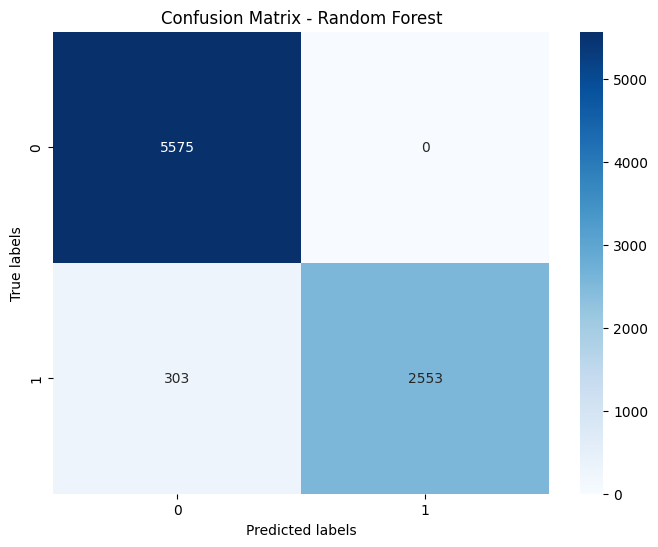

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=2, random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)

# Menghitung metrik evaluasi
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Menampilkan metrik evaluasi
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

##Random Forest (n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=2,  random_state=42)

Random Forest:
Accuracy: 0.9691614280631005
Precision: 1.0
Recall: 0.9089635854341737
F1 Score: 0.9523110785033015


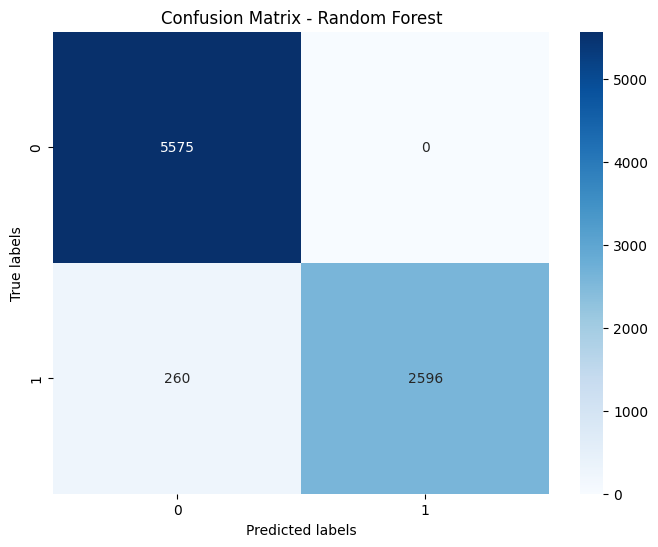

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=2,  random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest
rf_predictions = rf_model.predict(bow_unigram_test)

# Menghitung metrik evaluasi
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Menampilkan metrik evaluasi
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

##Random Forest (n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=2,  random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Menambahkan hyperparameter
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=2,  random_state=42)

# Melatih model Random Forest
rf_model.fit(bow_unigram_train, y_train)

# Melakukan prediksi dengan Random Forest pada data training
rf_train_predictions = rf_model.predict(bow_unigram_train)

# Melakukan prediksi dengan Random Forest pada data test
rf_test_predictions = rf_model.predict(bow_unigram_test)

In [ ]:
# Menghitung metrik evaluasi untuk data training
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_train_precision = precision_score(y_train, rf_train_predictions)
rf_train_recall = recall_score(y_train, rf_train_predictions)
rf_train_f1 = f1_score(y_train, rf_train_predictions)

# Menghitung metrik evaluasi untuk data test
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_test_precision = precision_score(y_test, rf_test_predictions)
rf_test_recall = recall_score(y_test, rf_test_predictions)
rf_test_f1 = f1_score(y_test, rf_test_predictions)
rf_test_conf_matrix = confusion_matrix(y_test, rf_test_predictions)

# Menampilkan metrik evaluasi untuk data training
print("Random Forest - Training Set:")
print("Accuracy:", rf_train_accuracy)
print("Precision:", rf_train_precision)
print("Recall:", rf_train_recall)
print("F1 Score:", rf_train_f1)

# Menampilkan metrik evaluasi untuk data test
print("\nRandom Forest - Test Set:")
print("Accuracy:", rf_test_accuracy)
print("Precision:", rf_test_precision)
print("Recall:", rf_test_recall)
print("F1 Score:", rf_test_f1)

Random Forest - Training Set:
Accuracy: 0.9643365491064368
Precision: 0.9997391757955139
Recall: 0.8949334578566426
F1 Score: 0.9444376000985586

Random Forest - Test Set:
Accuracy: 0.9691614280631005
Precision: 1.0
Recall: 0.9089635854341737
F1 Score: 0.9523110785033015


##Cross Validation

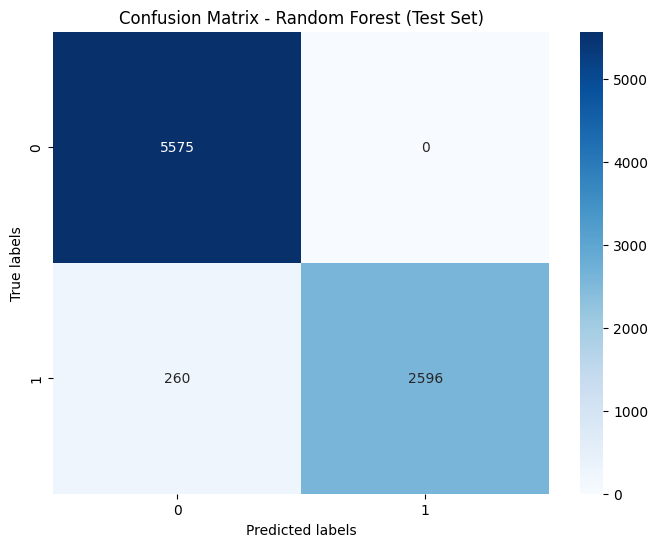

Cross-validation scores: [0.96323384 0.96382684 0.96876236 0.96164492 0.96599446]
Mean cross-validation score: 0.964692484749548


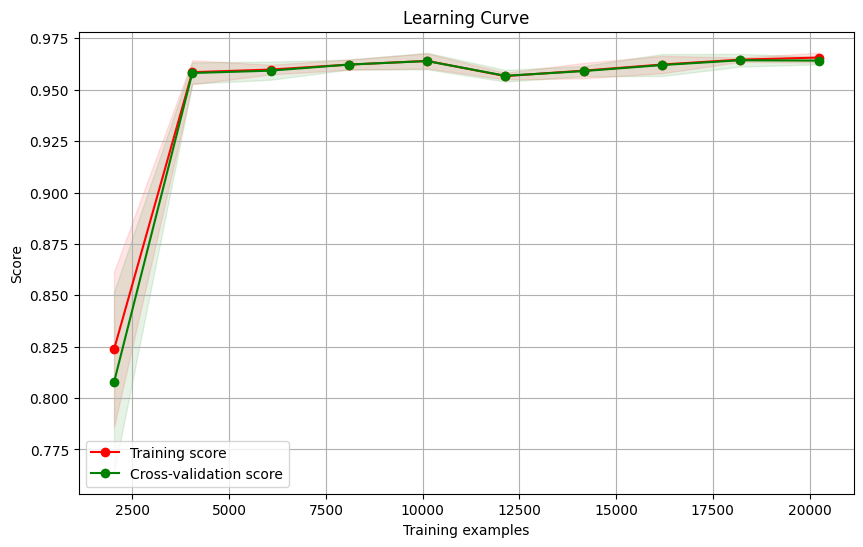

In [ ]:
# Menampilkan confusion matrix untuk data test
plt.figure(figsize=(8, 6))
sns.heatmap(rf_test_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.show()

# Menggunakan cross-validation untuk mendapatkan skor yang lebih robust
cv_scores = cross_val_score(rf_model, bow_unigram_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Plotting learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, bow_unigram_train, y_train, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()